# Dynamic Mode Decomposition (DMD)

In the previous two notebooks we developed the SVD and used it to decompose spatiotemporal data into **Empirical Orthogonal Functions** — spatial patterns ranked by variance. EOF analysis is powerful, but it has a fundamental limitation: the modes are constrained to be **orthogonal** and ranked by **variance**, not by dynamical relevance. The EOF modes mix together different physical processes that happen to project onto the same spatial pattern or time scale.

**Dynamic Mode Decomposition (DMD)** takes a different approach. Instead of asking *"what are the patterns of greatest variance?"*, DMD asks:

> **What are the spatiotemporal modes that each evolve at a single frequency and growth/decay rate?**

DMD discovers modes that behave like $\mathbf{\phi}_k \, e^{\omega_k t}$, where $\mathbf{\phi}_k$ is a spatial pattern and $\omega_k = \alpha_k + i \beta_k$ encodes both the growth/decay rate ($\alpha_k$) and oscillation frequency ($\beta_k$). This makes DMD particularly well-suited for identifying **oscillatory climate modes** like ENSO, the Madden-Julian Oscillation, or the annual cycle.

DMD was introduced by Peter Schmid (2010) in the fluid dynamics community, but has since been applied to a wide range of fields, including climate science. It can be thought of as a data-driven approximation to the **Koopman operator**, which describes the evolution of observables in a dynamical system. In this notebook, we will discuss the DMD algorithm and implement it using the SVD.

### The Koopman operator

For a discrete-time dynamical system $\mathbf{x}_{k+1} = \mathbf{f}(\mathbf{x}_k)$, the **Koopman operator** $\mathcal{K}$ is an infinite-dimensional *linear* operator that acts on **observable functions** $g: \mathbb{R}^n \to \mathbb{R}$:

$$(\mathcal{K} g)(\mathbf{x}) = g(\mathbf{f}(\mathbf{x}))$$

The key insight is revolutionary: **even for nonlinear systems, the Koopman operator is linear** (it operates on the function space, not the state space). This means that the eigendecomposition of $\mathcal{K}$ yields modes that evolve linearly in time — exactly what DMD computes.

DMD can be understood as a **finite-dimensional approximation** to the spectral analysis of the Koopman operator, using the state measurements as observables.

## Learning Goals

By the end of this notebook you should be able to:
1. Explain how DMD differs from EOF/PCA — modes with individual dynamics vs. modes ranked by variance
2. Derive and implement the exact DMD algorithm using the SVD
3. Interpret DMD eigenvalues in terms of oscillation frequencies and growth/decay rates
4. Apply DMD to real climate data and compare the results with EOF analysis
5. Understand the connection between DMD and the Koopman operator

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

np.set_printoptions(precision=4, suppress=True)

---
## Part 1: From SVD to DMD — The Key Idea

### The dynamical systems perspective

Suppose our data comes from some underlying dynamical system. At each time step $k$, the state $\mathbf{x}_k \in \mathbb{R}^n$ evolves according to some (possibly unknown, possibly nonlinear) dynamics:

$$\mathbf{x}_{k+1} = \mathbf{f}(\mathbf{x}_k)$$

DMD makes a key assumption: **the dynamics are approximately linear**. That is, there exists a matrix $\mathbf{A} \in \mathbb{R}^{n \times n}$ such that:

$$\mathbf{x}_{k+1} \approx \mathbf{A} \mathbf{x}_k$$

This is a strong assumption, but it's more reasonable than it might seem. The Koopman operator theory (which we'll touch on at the end) tells us that even for nonlinear systems, there exists a (potentially infinite dimension) linear operator that governs the evolution of *observables* of the system. DMD can be understood as a finite-dimensional approximation to this infinite-dimensional Koopman operator.

### The data matrices

Given snapshots $\mathbf{x}_1, \mathbf{x}_2, \ldots, \mathbf{x}_m$ arranged as columns of a data matrix (exactly as we did for the SVD), DMD constructs two overlapping matrices:

$$
\mathbf{X} = \begin{bmatrix} | & | & & | \\ \mathbf{x}_1 & \mathbf{x}_2 & \cdots & \mathbf{x}_{m-1} \\ | & | & & | \end{bmatrix}, \qquad
\mathbf{X}' = \begin{bmatrix} | & | & & | \\ \mathbf{x}_2 & \mathbf{x}_3 & \cdots & \mathbf{x}_{m} \\ | & | & & | \end{bmatrix}
$$

These are the "current" and "next" snapshot matrices. The linear relationship $\mathbf{x}_{k+1} \approx \mathbf{A} \mathbf{x}_k$ applied to all columns simultaneously gives:

$$\mathbf{X}' \approx \mathbf{A} \mathbf{X}$$

so $\mathbf{A}$ is the best-fit linear operator that advances the system by one time step.

### The problem

In principle, we could find $\mathbf{A}$ via the pseudoinverse:

$$\mathbf{A} = \mathbf{X}' \mathbf{X}^+$$

and then compute its eigendecomposition to get the DMD modes and eigenvalues. But in practice, $\mathbf{A}$ can be enormous (e.g., $10{,}000 \times 10{,}000$ for a gridded climate field). We don't want to form it explicitly.

The key insight of DMD is to use the **SVD of $\mathbf{X}$** to project $\mathbf{A}$ onto a low-rank subspace, making the eigendecomposition tractable.

---
## Part 2: The DMD Algorithm

Here is the standard ("exact") DMD algorithm, step by step.

### Step 1: Compute the SVD of $\mathbf{X}$

$$\mathbf{X} = \mathbf{U} \boldsymbol{\Sigma} \mathbf{V}^T$$

Optionally truncate to rank $r$: keep only the first $r$ columns of $\mathbf{U}$, the first $r$ singular values, and the first $r$ columns of $\mathbf{V}$.

### Step 2: Project $\mathbf{A}$ onto the SVD basis

Define the reduced operator:

$$\tilde{\mathbf{A}} = \mathbf{U}_r^T \mathbf{A} \mathbf{U}_r = \mathbf{U}_r^T \mathbf{X}' \mathbf{V}_r \boldsymbol{\Sigma}_r^{-1}$$

This is an $r \times r$ matrix — much smaller than $\mathbf{A}$. It captures the dynamics of $\mathbf{A}$ restricted to the subspace spanned by the leading SVD modes.

### Step 3: Eigendecomposition of $\tilde{\mathbf{A}}$

$$\tilde{\mathbf{A}} \mathbf{W} = \mathbf{W} \boldsymbol{\Lambda}$$

where $\boldsymbol{\Lambda} = \text{diag}(\lambda_1, \ldots, \lambda_r)$ contains the **DMD eigenvalues** and $\mathbf{W}$ contains the eigenvectors.

### Step 4: Recover the full-dimensional DMD modes

The **exact DMD modes** (following Tu et al., 2014) are:

$$\boldsymbol{\Phi} = \mathbf{X}' \mathbf{V}_r \boldsymbol{\Sigma}_r^{-1} \mathbf{W}$$

Each column $\boldsymbol{\phi}_k$ of $\boldsymbol{\Phi}$ is a DMD mode — a spatial pattern that evolves in time as $\boldsymbol{\phi}_k \lambda_k^t$.

### Interpreting the eigenvalues

The DMD eigenvalues $\lambda_k$ are complex numbers that encode the temporal dynamics of each mode:

- **Magnitude** $|\lambda_k|$: growth ($>1$), decay ($<1$), or neutral ($=1$) rate
- **Angle** $\angle \lambda_k$: oscillation frequency — the mode completes one full cycle when $\angle \lambda_k \cdot t = 2\pi$

Converting to continuous-time quantities (where $\Delta t$ is the time step):

$$\omega_k = \frac{\ln(\lambda_k)}{\Delta t} = \underbrace{\frac{\ln|\lambda_k|}{\Delta t}}_{\text{growth rate}} + i \underbrace{\frac{\angle \lambda_k}{\Delta t}}_{\text{frequency}}$$

The **period** of oscillation for mode $k$ is:

$$T_k = \frac{2\pi}{|\text{Im}(\omega_k)|} = \frac{2\pi \, \Delta t}{|\angle \lambda_k|}$$

---
## Part 3: Implementing DMD

Let's implement the exact DMD algorithm as a function, then test it on synthetic data before moving to real climate data.

In [ ]:
def dmd(X, r=None, dt=1.0):
    """
    Compute the exact Dynamic Mode Decomposition.
    
    Parameters
    ----------
    X : ndarray, shape (n, m)
        Data matrix with m snapshots as columns.
    r : int or None
        Truncation rank. If None, use all singular values.
    dt : float
        Time step between snapshots.
    
    Returns
    -------
    Phi : ndarray, shape (n, r)
        DMD modes (columns).
    lam : ndarray, shape (r,)
        DMD eigenvalues (discrete-time).
    omega : ndarray, shape (r,)
        DMD eigenvalues (continuous-time): omega = ln(lam) / dt.
    b : ndarray, shape (r,)
        Mode amplitudes (initial condition projection).
    """
    # Step 1: Build the time-shifted matrices
    X1 = X[:, :-1]   # x_1, ..., x_{m-1}
    X2 = X[:, 1:]    # x_2, ..., x_m
    
    # Step 2: SVD of X1
    U, s, Vt = np.linalg.svd(X1, full_matrices=False)
    
    if r is not None:
        U = U[:, :r]
        s = s[:r]
        Vt = Vt[:r, :]
    else:
        r = len(s)
    
    # Step 3: Reduced dynamics matrix
    Atilde = U.T @ X2 @ Vt.T @ np.diag(1.0 / s)
    
    # Step 4: Eigendecomposition of Atilde
    lam, W = np.linalg.eig(Atilde)
    
    # Step 5: Exact DMD modes
    Phi = X2 @ Vt.T @ np.diag(1.0 / s) @ W
    
    # Continuous-time eigenvalues
    omega = np.log(lam) / dt
    
    # Mode amplitudes from initial condition: x_1 = Phi @ b
    b = np.linalg.lstsq(Phi, X[:, 0], rcond=None)[0]
    
    return Phi, lam, omega, b

We also define some helper functions to do reconstructions and some plotting.

In [ ]:
def eof_analysis(X, n_modes=4):
    """EOF analysis of data matrix X (n_space x n_time). Returns EOFs, PCs, variance fractions."""
    X_centered = X - X.mean(axis=1, keepdims=True)
    U, s, Vt = np.linalg.svd(X_centered, full_matrices=False)
    var_frac = s**2 / np.sum(s**2)
    eofs = U[:, :n_modes]
    pcs = np.diag(s[:n_modes]) @ Vt[:n_modes, :]
    return eofs, pcs, var_frac, s


def dmd_reconstruct(Phi, lam, b, n_steps):
    """Reconstruct data from DMD modes: x(t_k) = Phi @ diag(b) @ lam^k."""
    dynamics = np.zeros((len(lam), n_steps), dtype=complex)
    for k in range(n_steps):
        dynamics[:, k] = b * lam**k
    return (Phi @ dynamics).real


def plot_eigenvalue_circle(lam, ax, title='DMD eigenvalues'):
    """Plot DMD eigenvalues on the unit circle."""
    theta = np.linspace(0, 2 * np.pi, 200)
    ax.plot(np.cos(theta), np.sin(theta), 'k-', alpha=0.3, linewidth=0.5)
    ax.scatter(lam.real, lam.imag, s=50, c='steelblue', edgecolors='k',
               linewidth=0.5, zorder=5)
    ax.set_xlabel('Re($\\lambda$)')
    ax.set_ylabel('Im($\\lambda$)')
    ax.set_title(title)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.axhline(0, color='k', linewidth=0.5)
    ax.axvline(0, color='k', linewidth=0.5)

---
## Part 4: DMD on Synthetic Data — Mixing Dynamics

Let's first test DMD on data with known dynamics. We'll construct a spatiotemporal signal that is a mixture of oscillatory modes with known frequencies and growth/decay rates, and verify that DMD recovers them.

**Important detail**: DMD decomposes data into modes that evolve as $\boldsymbol{\phi}_k \lambda_k^t$, where $\lambda_k$ is complex. For real-valued data, these modes come in **conjugate pairs**: $(\lambda, \bar{\lambda})$ and $(\boldsymbol{\phi}, \bar{\boldsymbol{\phi}})$. Each conjugate pair corresponds to one physical oscillation. So three oscillation frequencies require six DMD modes.

To make our synthetic data a fair test, we generate it directly from a discrete-time linear system $\mathbf{x}_{k+1} = \mathbf{A}\mathbf{x}_k$ with known eigenvalues. This ensures the data genuinely satisfies the linear dynamics assumption that DMD requires.

In [ ]:
# Define the spatial domain and time steps
n = 200       # spatial points
m = 200       # time steps
dt = 0.05     # time step

x = np.linspace(-5, 5, n)
t = np.arange(m) * dt

# Define three oscillatory modes with known frequencies and decay rates
# Each mode has a complex spatial pattern (phi) and a complex eigenvalue (lambda)
# Real data requires conjugate pairs: (phi, lambda) and (conj(phi), conj(lambda))

omega_true = np.array([2.0, 5.0, 0.5])     # oscillation frequencies (rad/s)
decay_true = np.array([0.0, -0.1, 0.0])     # growth/decay rates
amp_true = np.array([3.0, 1.5, 2.0])        # mode amplitudes

# Discrete-time eigenvalues: lambda = exp((alpha + i*omega) * dt)
lam_true = np.exp((decay_true + 1j * omega_true) * dt)

print("True discrete-time eigenvalues:")
for j in range(3):
    print(f"  omega={omega_true[j]:.1f} rad/s, decay={decay_true[j]:.1f}: "
          f"|lambda|={np.abs(lam_true[j]):.6f}, angle={np.angle(lam_true[j]):.4f} rad")

# Complex spatial modes (with both real and imaginary parts for each)
# This ensures the data has rank 6, not rank 3
phi1 = np.exp(-x**2) + 0.5j * np.exp(-(x - 1)**2)
phi2 = x * np.exp(-x**2 / 4) + 0.3j * np.exp(-x**2 / 2)
phi3 = np.cos(np.pi * x / 10) + 0.4j * np.sin(np.pi * x / 8)
modes = np.column_stack([phi1, phi2, phi3])  # (n, 3)

# Generate data: x(t_k) = sum_j 2 * Re(b_j * phi_j * lambda_j^k)
X_synth = np.zeros((n, m))
for k in range(m):
    for j in range(3):
        X_synth[:, k] += 2 * (amp_true[j] * modes[:, j] * lam_true[j]**k).real

# Add small noise
rng = np.random.default_rng(42)
X_synth += 0.01 * rng.standard_normal(X_synth.shape)

print(f"\nSynthetic data shape: {X_synth.shape}")
print(f"True frequencies: {omega_true} rad/s")
print(f"True periods: {2*np.pi/omega_true} time units")

True discrete-time eigenvalues:
  omega=2.0 rad/s, decay=0.0: |lambda|=1.000000, angle=0.1000 rad
  omega=5.0 rad/s, decay=-0.1: |lambda|=0.995012, angle=0.2500 rad
  omega=0.5 rad/s, decay=0.0: |lambda|=1.000000, angle=0.0250 rad

Synthetic data shape: (200, 200)
True frequencies: [2.  5.  0.5] rad/s
True periods: [ 3.1416  1.2566 12.5664] time units


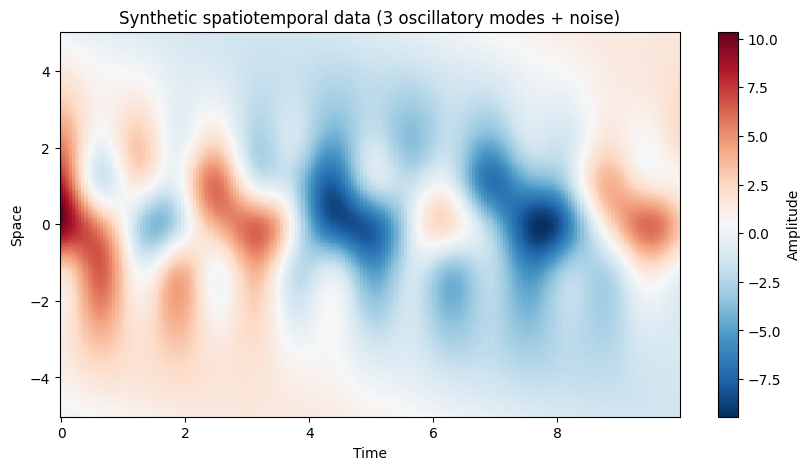

In [ ]:
# Visualize the synthetic data
fig, ax = plt.subplots(figsize=(10, 5))
im = ax.pcolormesh(t, x, X_synth, cmap='RdBu_r', shading='auto')
ax.set_xlabel('Time')
ax.set_ylabel('Space')
ax.set_title('Synthetic spatiotemporal data (3 oscillatory modes + noise)')
plt.colorbar(im, ax=ax, label='Amplitude')

In [ ]:
# Apply DMD with rank truncation (6 modes = 3 conjugate pairs)
Phi_s, lam_s, omega_s, b_s = dmd(X_synth, r=6, dt=dt)

print("DMD eigenvalues (continuous-time):")
print(f"  {'Frequency (rad/s)':>20s}  {'Period':>12s}  {'Growth rate':>12s}  {'|lambda|':>10s}")
for k in range(len(omega_s)):
    freq = np.abs(omega_s[k].imag)
    period = 2 * np.pi / freq if freq > 1e-10 else np.inf
    growth = omega_s[k].real
    print(f"  {freq:>20.4f}  {period:>12.3f}  {growth:>12.6f}  {np.abs(lam_s[k]):>10.6f}")

print(f"\nTrue frequencies for comparison: {omega_true} rad/s")
print(f"True decay rates: {decay_true}")

DMD eigenvalues (continuous-time):
     Frequency (rad/s)        Period   Growth rate    |lambda|
                5.0042         1.256     -0.119827    0.994027
                5.0042         1.256     -0.119827    0.994027
                1.9995         3.142     -0.000349    0.999983
                1.9995         3.142     -0.000349    0.999983
                0.5000        12.567      0.000171    1.000009
                0.5000        12.567      0.000171    1.000009

True frequencies for comparison: [2.  5.  0.5] rad/s
True decay rates: [ 0.  -0.1  0. ]


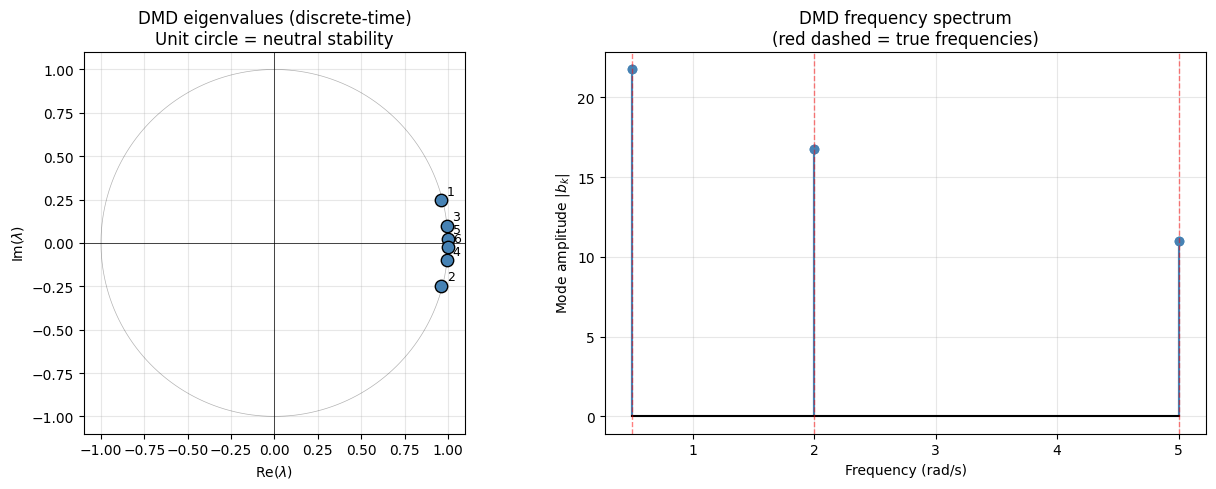

In [ ]:
# Visualize the DMD eigenvalue spectrum
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Left: eigenvalues in the complex plane (unit circle)
theta_circle = np.linspace(0, 2 * np.pi, 200)
axes[0].plot(np.cos(theta_circle), np.sin(theta_circle), 'k-', alpha=0.3, linewidth=0.5)
axes[0].scatter(lam_s.real, lam_s.imag, s=80, c='steelblue', edgecolors='k', zorder=5)
for k in range(len(lam_s)):
    axes[0].annotate(f'{k+1}', (lam_s[k].real + 0.03, lam_s[k].imag + 0.03), fontsize=9)
axes[0].set_xlabel('Re($\\lambda$)')
axes[0].set_ylabel('Im($\\lambda$)')
axes[0].set_title('DMD eigenvalues (discrete-time)\nUnit circle = neutral stability')
axes[0].set_aspect('equal')
axes[0].grid(True, alpha=0.3)
axes[0].axhline(0, color='k', linewidth=0.5)
axes[0].axvline(0, color='k', linewidth=0.5)

# Right: frequency spectrum (imaginary part of continuous-time eigenvalues)
freqs = np.abs(omega_s.imag)
amplitudes = np.abs(b_s)
axes[1].stem(freqs, amplitudes, linefmt='steelblue', markerfmt='o', basefmt='k-')
# Mark true frequencies
for f_true in [0.5, 2.0, 5.0]:
    axes[1].axvline(f_true, color='red', linestyle='--', alpha=0.5, linewidth=1)
axes[1].set_xlabel('Frequency (rad/s)')
axes[1].set_ylabel('Mode amplitude $|b_k|$')
axes[1].set_title('DMD frequency spectrum\n(red dashed = true frequencies)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()

Relative reconstruction error: 0.0209


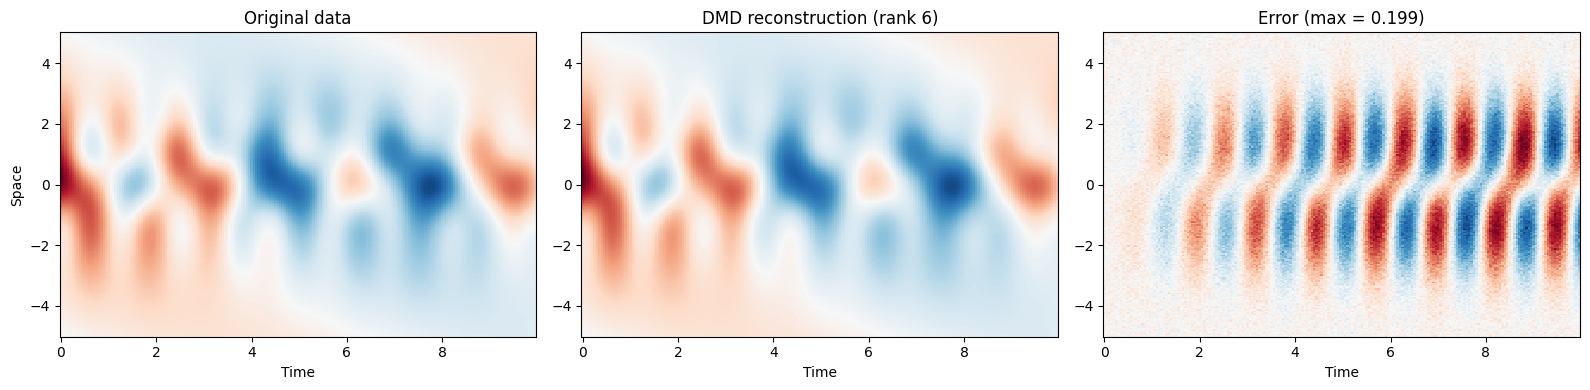

In [ ]:
# Reconstruct the data from DMD modes
# x(t) = Phi @ diag(b) @ [lam^0, lam^1, ..., lam^{m-1}]
time_dynamics = np.zeros((len(lam_s), m), dtype=complex)
for k in range(m):
    time_dynamics[:, k] = b_s * lam_s**k

X_dmd_recon = (Phi_s @ time_dynamics).real

fig, axes = plt.subplots(1, 3, figsize=(16, 4))
vmax = np.abs(X_synth).max()

axes[0].pcolormesh(t, x, X_synth, cmap='RdBu_r', shading='auto', vmin=-vmax, vmax=vmax)
axes[0].set_title('Original data')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Space')

axes[1].pcolormesh(t, x, X_dmd_recon, cmap='RdBu_r', shading='auto', vmin=-vmax, vmax=vmax)
axes[1].set_title('DMD reconstruction (rank 6)')
axes[1].set_xlabel('Time')

error = X_synth - X_dmd_recon
axes[2].pcolormesh(t, x, error, cmap='RdBu_r', shading='auto')
axes[2].set_title(f'Error (max = {np.abs(error).max():.3f})')
axes[2].set_xlabel('Time')

plt.tight_layout()

rel_error = np.linalg.norm(error, 'fro') / np.linalg.norm(X_synth, 'fro')
print(f"Relative reconstruction error: {rel_error:.4f}")

DMD has recovered the oscillation frequencies from the data. Notice that:

- Eigenvalues come in **conjugate pairs** (since the data is real, each oscillatory mode produces $\pm \omega$)
- Eigenvalues **on** the unit circle ($|\lambda| = 1$) correspond to purely oscillatory (non-decaying) modes
- Eigenvalues **inside** the unit circle ($|\lambda| < 1$) correspond to decaying modes (the one at $\omega \approx 5$ rad/s, which we gave a decay rate of $-0.1$)
- The DMD frequency spectrum cleanly identifies the three true frequencies

Compare this with what the SVD/EOF would give: the SVD modes are ranked by variance and forced to be orthogonal, which can mix together different frequency components into single modes. DMD separates them by frequency.

**Why did we need rank 6?** Each oscillation frequency in real-valued data requires a conjugate pair of complex modes ($e^{i\omega t}$ and $e^{-i\omega t}$), contributing 2 to the rank. Three frequencies means rank 6. This is an important practical consideration: always set $r \geq 2 \times$ (number of expected oscillatory modes).

---
## Part 5: EOF vs. DMD — A Direct Comparison

Let's apply both EOF analysis and DMD to the same synthetic data and compare what each method extracts.

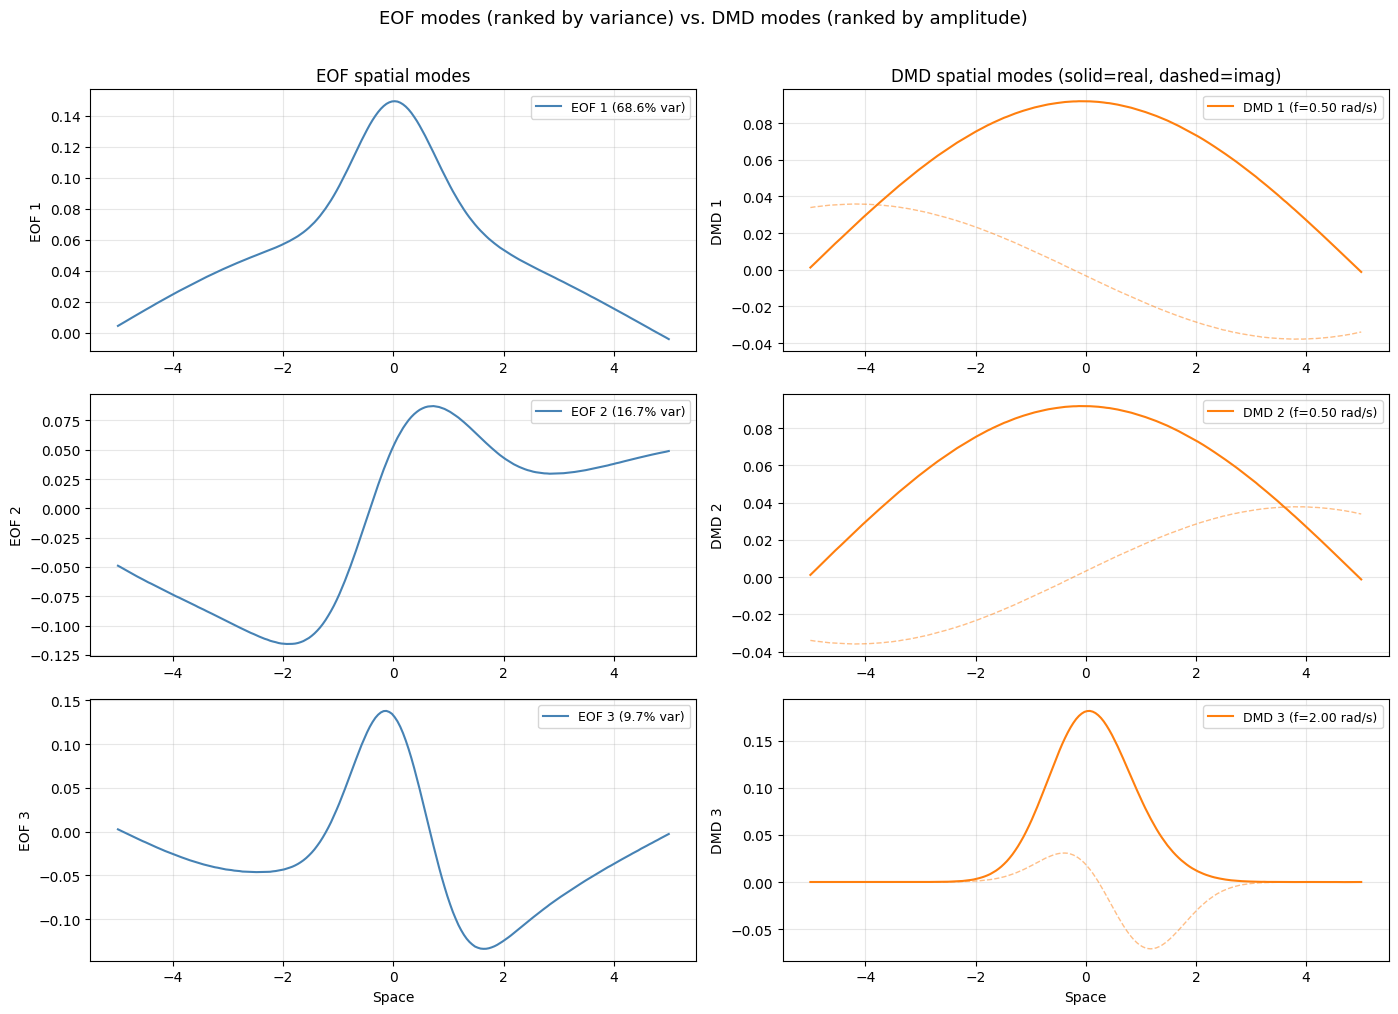

In [ ]:
# EOF analysis (SVD of the full data matrix)
X_centered = X_synth - X_synth.mean(axis=1, keepdims=True)
U_eof, s_eof, Vt_eof = np.linalg.svd(X_centered, full_matrices=False)

fig, axes = plt.subplots(3, 2, figsize=(14, 10))

# Left column: EOF spatial modes and temporal coefficients
for k in range(3):
    ax_space = axes[k, 0]
    ax_space.plot(x, U_eof[:, k], 'steelblue', linewidth=1.5,
                  label=f'EOF {k+1} ({s_eof[k]**2/np.sum(s_eof**2)*100:.1f}% var)')
    ax_space.set_ylabel(f'EOF {k+1}')
    ax_space.legend(loc='upper right', fontsize=9)
    ax_space.grid(True, alpha=0.3)
    if k == 0:
        ax_space.set_title('EOF spatial modes')

# Right column: DMD spatial modes (real part)
# Sort DMD modes by amplitude
sort_idx = np.argsort(-np.abs(b_s))
for k in range(3):
    ax_space = axes[k, 1]
    idx = sort_idx[k]
    freq_k = np.abs(omega_s[idx].imag)
    ax_space.plot(x, Phi_s[:, idx].real, 'C1', linewidth=1.5,
                  label=f'DMD {k+1} (f={freq_k:.2f} rad/s)')
    ax_space.plot(x, Phi_s[:, idx].imag, 'C1', linewidth=1, alpha=0.5, linestyle='--')
    ax_space.set_ylabel(f'DMD {k+1}')
    ax_space.legend(loc='upper right', fontsize=9)
    ax_space.grid(True, alpha=0.3)
    if k == 0:
        ax_space.set_title('DMD spatial modes (solid=real, dashed=imag)')

axes[-1, 0].set_xlabel('Space')
axes[-1, 1].set_xlabel('Space')
plt.suptitle('EOF modes (ranked by variance) vs. DMD modes (ranked by amplitude)',
             fontsize=13, y=1.01)
plt.tight_layout()

Key differences between the two decompositions:

| Property | EOF / PCA | DMD |
|----------|-----------|-----|
| **Modes are** | Orthogonal, real | Non-orthogonal, complex |
| **Ranked by** | Variance explained | Amplitude / dynamical relevance |
| **Temporal behavior** | Arbitrary (determined by projection) | Single frequency per mode |
| **Growth/decay** | Not directly captured | Encoded in eigenvalue magnitude |
| **Physical interpretation** | Patterns of maximum variance | Patterns with coherent dynamics |
| **Best for** | Dimensionality reduction, statistical summary | Identifying oscillatory modes, forecasting |

Notice the key difference:

- The **EOF/PC** captures the pattern of maximum variance, but its time series mixes together multiple frequencies (trend, ENSO, decadal variability). You'd need to filter the PC time series to isolate ENSO.
- The **DMD mode** directly isolates the oscillatory component at the ENSO frequency. Its time evolution is a clean sinusoid at that frequency, by construction.

This is the fundamental trade-off: EOFs are optimal for variance, DMD modes are optimal for identifying coherent dynamics.

# EOF vs DMD on Classical Dynamical Systems

In the previous notebooks we introduced the SVD/EOF and DMD decompositions and applied them to climate data. But how well do these methods work on systems with *known* dynamics? Testing on classical equations lets us check whether each method recovers what we expect — and see clearly where it breaks down.

This notebook applies both EOF and DMD to three systems that span a spectrum of dynamical complexity:

| System | Type | Dimension | Expected DMD performance |
|--------|------|-----------|-------------------------|
| **Lorenz attractor** | Low-dimensional chaos | 3 state variables | Poor — chaos violates the linear dynamics assumption |
| **Kuramoto-Sivashinsky equation** | Spatiotemporal chaos | PDE on 1D domain | Mixed — captures some coherent structures |
| **Shallow water equations** | Wave dynamics | PDE on 1D domain | Excellent — wave modes are inherently oscillatory |

The arc of the notebook is: **DMD failure → partial success → clean success**. This builds intuition for when DMD is the right tool for Earth science problems.

---
# System 1: The Lorenz Attractor — Low-Dimensional Chaos

The Lorenz system is the canonical example of deterministic chaos:

$$\dot{x} = \sigma(y - x), \qquad \dot{y} = x(\rho - z) - y, \qquad \dot{z} = xy - \beta z$$

With the classical parameters ($\sigma = 10$, $\rho = 28$, $\beta = 8/3$), the trajectory is confined to a strange attractor — a fractal set with sensitive dependence on initial conditions.

The system is only 3-dimensional, which is too small for a meaningful "spatial mode" analysis. To create a high-dimensional dataset analogous to the spatiotemporal fields in the other notebooks, we use **time-delay embedding**: we take a single scalar observable $x(t)$ and construct a matrix of lagged copies:

$$\mathbf{H} = \begin{bmatrix} x(t_1) & x(t_2) & \cdots & x(t_{m-d+1}) \\ x(t_2) & x(t_3) & \cdots & x(t_{m-d+2}) \\ \vdots & & & \vdots \\ x(t_d) & x(t_{d+1}) & \cdots & x(t_m) \end{bmatrix}$$

Each column of $\mathbf{H}$ is a "snapshot" of the time-delay embedded state, and the rows play the role of "spatial" coordinates. This is grounded in **Takens' theorem**, which guarantees that such an embedding preserves the topology of the attractor.

In [ ]:
# Lorenz system parameters
sigma, rho, beta = 10.0, 28.0, 8.0 / 3.0

def lorenz(t, state):
    x, y, z = state
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

# Integrate for a long time, discarding transient
dt_lorenz = 0.01
t_span = (0, 100)
t_eval = np.arange(0, 100, dt_lorenz)
sol = solve_ivp(lorenz, t_span, [1.0, 1.0, 1.0], t_eval=t_eval,
                method='RK45', rtol=1e-10, atol=1e-12)

# Discard transient (first 20 time units)
i_start = int(20 / dt_lorenz)
x_lorenz = sol.y[0, i_start:]
t_lorenz = sol.t[i_start:] - sol.t[i_start]

print(f"Lorenz trajectory: {len(x_lorenz)} time steps, dt={dt_lorenz}")
print(f"Time range: 0 to {t_lorenz[-1]:.1f} time units")

Lorenz trajectory: 8000 time steps, dt=0.01
Time range: 0 to 80.0 time units


In [ ]:
# Build the time-delay (Hankel) matrix
d = 100   # embedding dimension (number of delays)
n_cols = len(x_lorenz) - d + 1

# Subsample to keep the matrix manageable
step = 5
cols = np.arange(0, n_cols, step)
H = np.zeros((d, len(cols)))
for i, c in enumerate(cols):
    H[:, i] = x_lorenz[c:c + d]

# Time axis for Hankel columns
t_pc = cols * dt_lorenz

print(f"Matrix shape: {H.shape} (d={d} delays, {H.shape[1]} windows)")
print(f"Effective dt between columns: {step * dt_lorenz}")

Matrix shape: (100, 1581) (d=100 delays, 1581 windows)
Effective dt between columns: 0.05


### EOF analysis of the Lorenz system

Variance in first 4 modes: 94.1%
Modes needed for 90% variance: 4


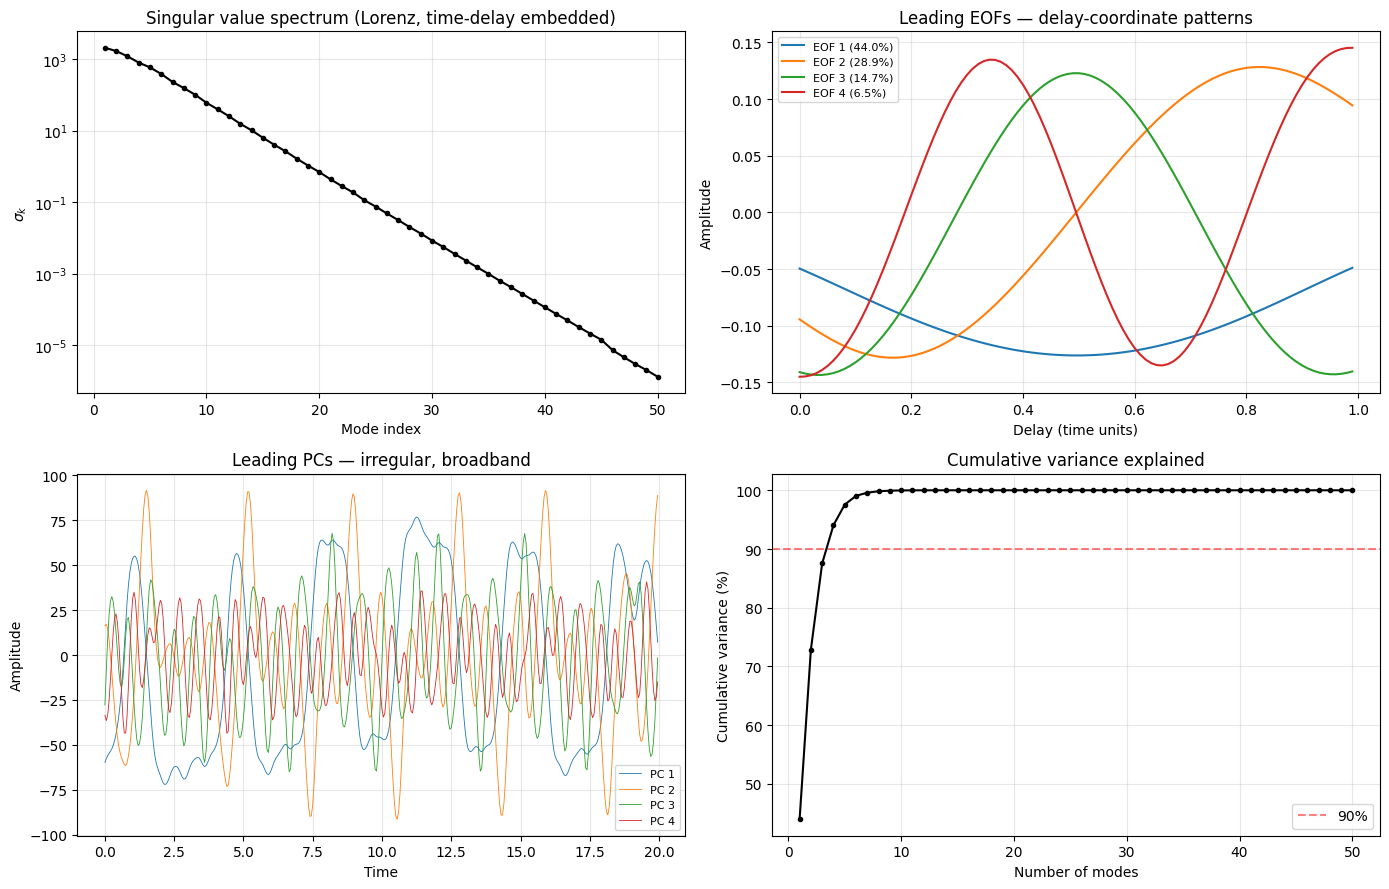

In [ ]:
eofs_l, pcs_l, var_frac_l, s_l = eof_analysis(H, n_modes=6)

fig, axes = plt.subplots(2, 2, figsize=(14, 9))

# Singular value spectrum
axes[0, 0].semilogy(np.arange(1, min(51, len(s_l) + 1)), s_l[:50], 'ko-', markersize=3)
axes[0, 0].set_xlabel('Mode index')
axes[0, 0].set_ylabel('$\\sigma_k$')
axes[0, 0].set_title('Singular value spectrum (Lorenz, time-delay embedded)')
axes[0, 0].grid(True, alpha=0.3)

# Leading EOFs (delay coordinate patterns)
for k in range(4):
    axes[0, 1].plot(np.arange(d) * dt_lorenz, eofs_l[:, k],
                    label=f'EOF {k+1} ({var_frac_l[k]*100:.1f}%)')
axes[0, 1].set_xlabel('Delay (time units)')
axes[0, 1].set_ylabel('Amplitude')
axes[0, 1].set_title('Leading EOFs — delay-coordinate patterns')
axes[0, 1].legend(fontsize=8)
axes[0, 1].grid(True, alpha=0.3)

# Leading PCs
n_show_l = min(400, len(t_pc))
for k in range(4):
    axes[1, 0].plot(t_pc[:n_show_l], pcs_l[k, :n_show_l], linewidth=0.6,
                    label=f'PC {k+1}')
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('Amplitude')
axes[1, 0].set_title('Leading PCs — irregular, broadband')
axes[1, 0].legend(fontsize=8)
axes[1, 0].grid(True, alpha=0.3)

# Cumulative variance
cum_l = np.cumsum(var_frac_l)
axes[1, 1].plot(np.arange(1, min(51, len(cum_l) + 1)), cum_l[:50] * 100, 'ko-', markersize=3)
axes[1, 1].axhline(90, color='r', linestyle='--', alpha=0.5, label='90%')
axes[1, 1].set_xlabel('Number of modes')
axes[1, 1].set_ylabel('Cumulative variance (%)')
axes[1, 1].set_title('Cumulative variance explained')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()

r90_l = np.argmax(cum_l >= 0.90) + 1
print(f"Variance in first 4 modes: {cum_l[3]*100:.1f}%")
print(f"Modes needed for 90% variance: {r90_l}")

The EOF analysis shows:
- The singular values decay gradually — many modes are needed to capture the attractor's structure
- The PCs are **irregular and broadband**, reflecting the chaotic dynamics
- No single EOF/PC pair oscillates at a clean frequency

### DMD analysis of the Lorenz system

DMD eigenvalue magnitudes: [0.9451 0.9451 0.9447 0.9435 0.9435 0.9431 0.9431 0.9368 0.9368 0.9367
 0.9367 0.9219 0.9219 0.9103 0.9103]
All |lambda| < 1? True
Relative reconstruction error: 0.996


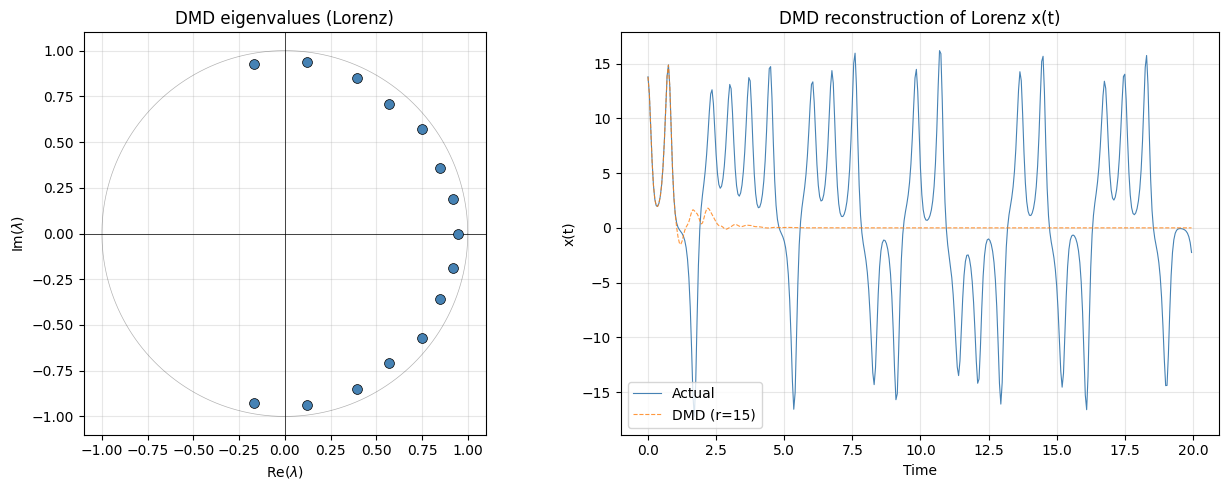

In [ ]:
# DMD on the Hankel matrix
r_lorenz = 15
dt_hankel = step * dt_lorenz  # effective time step between Hankel columns
Phi_l, lam_l, omega_l, b_l = dmd(H, r=r_lorenz, dt=dt_hankel)

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Eigenvalues on the complex plane
plot_eigenvalue_circle(lam_l, axes[0], 'DMD eigenvalues (Lorenz)')

# DMD reconstruction vs actual
X_dmd_l = dmd_reconstruct(Phi_l, lam_l, b_l, H.shape[1])

n_plot = 400
axes[1].plot(t_pc[:n_plot], H[0, :n_plot], 'steelblue', linewidth=0.8, label='Actual')
axes[1].plot(t_pc[:n_plot], X_dmd_l[0, :n_plot], 'C1', linewidth=0.8, alpha=0.8,
             label=f'DMD (r={r_lorenz})', linestyle='--')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('x(t)')
axes[1].set_title('DMD reconstruction of Lorenz x(t)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()

# Reconstruction error
rel_err = np.linalg.norm(H - X_dmd_l, 'fro') / np.linalg.norm(H, 'fro')
print(f"DMD eigenvalue magnitudes: {np.sort(np.abs(lam_l))[::-1]}")
print(f"All |lambda| < 1? {np.all(np.abs(lam_l) < 1.001)}")
print(f"Relative reconstruction error: {rel_err:.3f}")

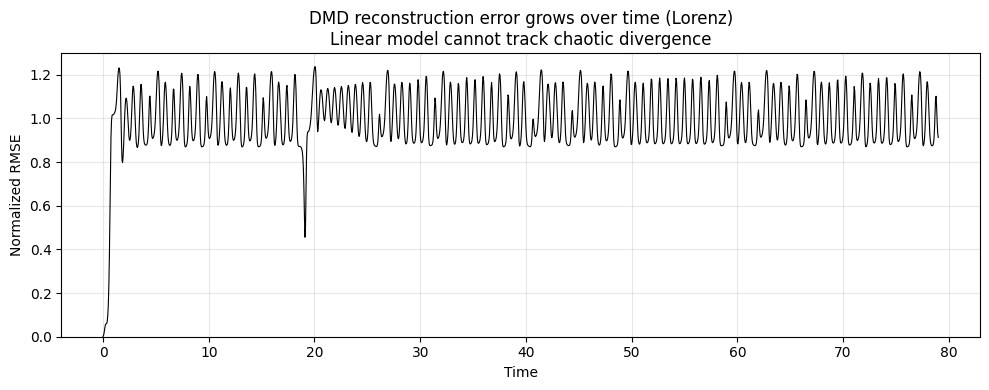

In [ ]:
# Show how DMD error grows with time — hallmark of chaos
errors_over_time = np.sqrt(np.mean((H - X_dmd_l)**2, axis=0))
signal_rms = np.sqrt(np.mean(H**2, axis=0))

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(t_pc, errors_over_time / signal_rms.mean(), 'k-', linewidth=0.8)
ax.set_xlabel('Time')
ax.set_ylabel('Normalized RMSE')
ax.set_title('DMD reconstruction error grows over time (Lorenz)\n'
             'Linear model cannot track chaotic divergence')
ax.grid(True, alpha=0.3)
ax.set_ylim(bottom=0)
plt.tight_layout()

### Lorenz: Key observations

- **DMD eigenvalues** are all inside or very near the unit circle. DMD interprets the chaotic attractor as a collection of *damped* oscillatory modes, because from a linear perspective chaos looks like transient ringing.
- **Reconstruction degrades** over time: DMD fits the initial portion well but diverges as the chaotic trajectory does something unpredictable (from the linear model's perspective).
- **EOF** captures the variance structure of the attractor but the PCs are irregular — there is no single dominant oscillation frequency.
- **Takeaway**: For low-dimensional chaos, neither EOF nor DMD gives a clean, physically interpretable decomposition. More advanced methods (e.g., extended DMD with nonlinear observables) are needed.

---
# System 2: The Kuramoto-Sivashinsky Equation — Spatiotemporal Chaos

The Kuramoto-Sivashinsky (KS) equation is a classic model for spatiotemporal chaos:

$$u_t + u \, u_x + u_{xx} + u_{xxxx} = 0$$

on a periodic domain $x \in [0, L]$. The $u_{xx}$ term is an *anti-diffusion* (negative viscosity) that drives instability at intermediate scales, while the $u_{xxxx}$ term provides damping at small scales. The nonlinear advection $u \, u_x$ transfers energy between scales. The result is chaotic dynamics with a characteristic "cell" size that depends on the domain length $L$.

The KS equation is a standard testbed for data-driven methods, featured in Chapter 7 of Brunton & Kutz. Unlike the Lorenz system, it is a PDE, so the spatial structure is rich and we can directly compare EOF spatial modes with DMD spatial modes.

### Numerical method

We use the **pseudospectral method**: spatial derivatives are computed in Fourier space (which is exact for periodic domains), and time integration uses **ETDRK4** (exponential time differencing with RK4 for the nonlinear term). The stiff linear terms ($u_{xx}$ and $u_{xxxx}$) are handled exactly via an integrating factor, while the nonlinear advection is advanced with RK4.

In [ ]:
def solve_ks(L, N, dt, n_steps, n_save_every=1):
    """
    Solve the Kuramoto-Sivashinsky equation using pseudospectral + ETDRK4.
    
    u_t + u*u_x + u_xx + u_xxxx = 0, periodic on [0, L]
    
    Uses exponential time differencing (integrating factor) to handle
    the stiff linear terms exactly, with RK4 for the nonlinear part.
    """
    x = np.linspace(0, L, N, endpoint=False)
    # Angular wavenumbers
    k = np.fft.rfftfreq(N, d=L / (2 * np.pi * N))
    
    # Linear operator in Fourier space: L_hat = k^2 - k^4
    L_hat = k**2 - k**4
    
    # Integrating factor for ETDRK4
    E = np.exp(L_hat * dt)
    E2 = np.exp(L_hat * dt / 2)
    
    def nonlinear(u):
        """Compute -u * u_x in Fourier space."""
        u_hat = np.fft.rfft(u)
        ux = np.fft.irfft(1j * k * u_hat, n=N)
        return np.fft.rfft(-u * ux)
    
    # Initial condition: superposition of low wavenumber perturbations
    rng = np.random.default_rng(42)
    u = np.zeros(N)
    for kk in range(1, 6):
        phase = rng.uniform(0, 2 * np.pi)
        u += rng.standard_normal() * np.cos(2 * np.pi * kk * x / L + phase)
    
    u_hat = np.fft.rfft(u)
    
    # Time integration with integrating factor + RK4
    snapshots = []
    for step in range(n_steps):
        if step % n_save_every == 0:
            snapshots.append(np.fft.irfft(u_hat, n=N).copy())
        
        # RK4 with integrating factor
        Nu1 = nonlinear(np.fft.irfft(u_hat, n=N))
        a = E2 * u_hat + (dt / 2) * E2 * Nu1
        
        Nu2 = nonlinear(np.fft.irfft(a, n=N))
        b = E2 * u_hat + (dt / 2) * Nu2
        
        Nu3 = nonlinear(np.fft.irfft(b, n=N))
        c = E2 * a + (dt / 2) * (2 * Nu3 - E2 * Nu1)
        
        Nu4 = nonlinear(np.fft.irfft(c, n=N))
        u_hat = E * u_hat + (dt / 6) * (E * Nu1 + 2 * E2 * (Nu2 + Nu3) + Nu4)
    
    snapshots = np.array(snapshots).T  # shape: (N, n_snapshots)
    return x, snapshots

In [ ]:
# Solve KS equation
L_ks = 100       # domain length
N_ks = 256       # spatial grid points
dt_ks = 0.05     # time step
n_steps_ks = 40000  # total steps (T = 2000)
save_every = 20  # save every 20 steps -> dt_save = 1.0

# Spin up for 500 time units, then collect data
n_spinup = 10000  # 500 time units
x_ks_full, snaps_full = solve_ks(L_ks, N_ks, dt_ks, n_spinup + n_steps_ks, save_every)

# Discard spin-up
n_spinup_snaps = n_spinup // save_every
X_ks = snaps_full[:, n_spinup_snaps:]
x_ks = x_ks_full
dt_save = dt_ks * save_every
t_ks = np.arange(X_ks.shape[1]) * dt_save

print(f"KS data shape: {X_ks.shape} (space x time)")
print(f"Spatial points: {N_ks}, domain: [0, {L_ks}]")
print(f"Time steps: {X_ks.shape[1]}, dt_save={dt_save}, T={t_ks[-1]:.0f}")

KS data shape: (256, 2000) (space x time)
Spatial points: 256, domain: [0, 100]
Time steps: 2000, dt_save=1.0, T=1999


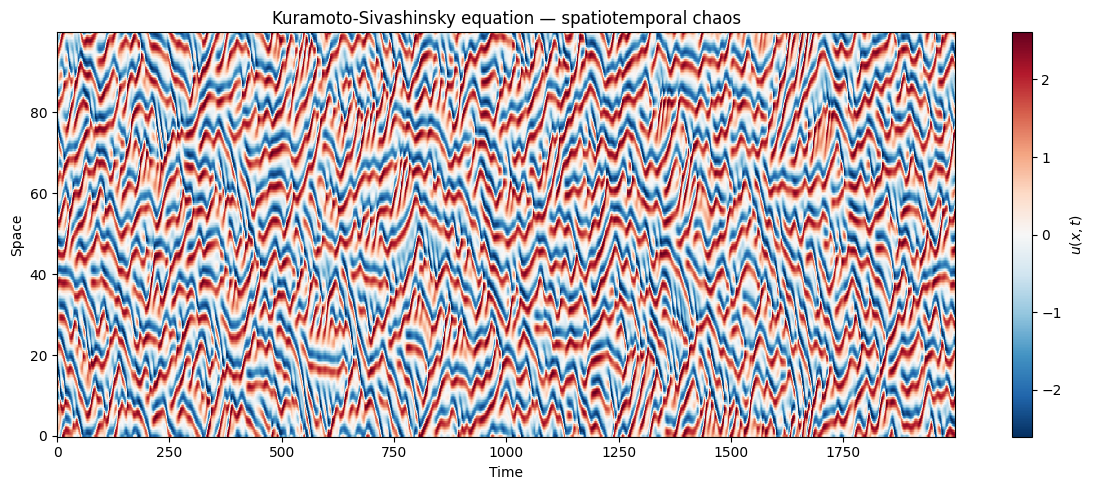

In [ ]:
# Visualize KS spatiotemporal dynamics
fig, ax = plt.subplots(figsize=(12, 5))
vmax = np.percentile(np.abs(X_ks), 99)
im = ax.pcolormesh(t_ks, x_ks, X_ks, cmap='RdBu_r', shading='auto',
                   vmin=-vmax, vmax=vmax)
ax.set_xlabel('Time')
ax.set_ylabel('Space')
ax.set_title('Kuramoto-Sivashinsky equation — spatiotemporal chaos')
plt.colorbar(im, ax=ax, label='$u(x, t)$')
plt.tight_layout()

### EOF analysis of the KS equation

Modes needed for 90% variance: 29


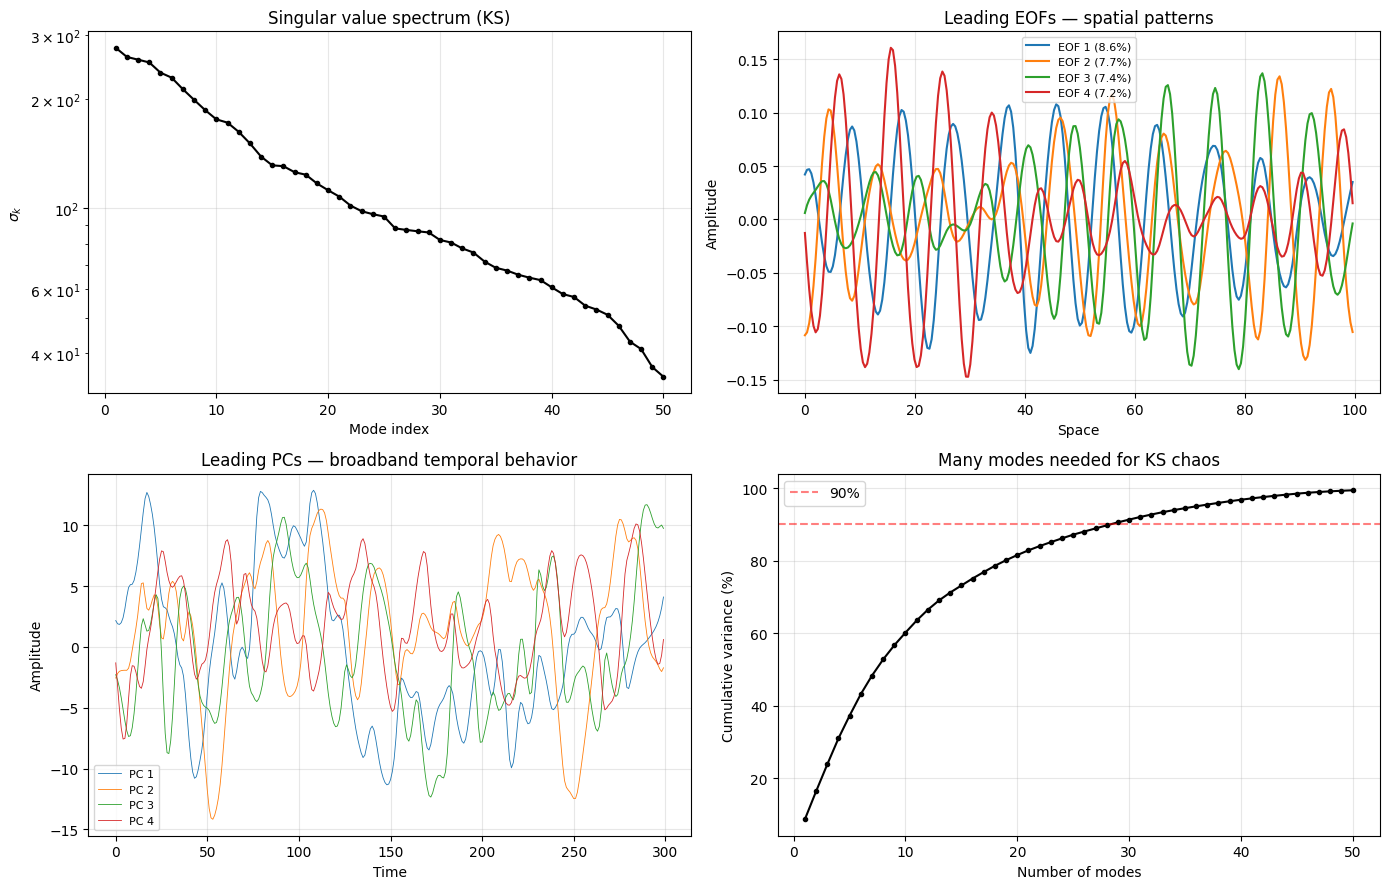

In [ ]:
eofs_ks, pcs_ks, var_frac_ks, s_ks = eof_analysis(X_ks, n_modes=6)

fig, axes = plt.subplots(2, 2, figsize=(14, 9))

# Singular value spectrum
axes[0, 0].semilogy(np.arange(1, 51), s_ks[:50], 'ko-', markersize=3)
axes[0, 0].set_xlabel('Mode index')
axes[0, 0].set_ylabel('$\\sigma_k$')
axes[0, 0].set_title('Singular value spectrum (KS)')
axes[0, 0].grid(True, alpha=0.3)

# Leading EOFs
for k in range(4):
    axes[0, 1].plot(x_ks, eofs_ks[:, k],
                    label=f'EOF {k+1} ({var_frac_ks[k]*100:.1f}%)')
axes[0, 1].set_xlabel('Space')
axes[0, 1].set_ylabel('Amplitude')
axes[0, 1].set_title('Leading EOFs — spatial patterns')
axes[0, 1].legend(fontsize=8)
axes[0, 1].grid(True, alpha=0.3)

# Leading PCs (show first 300 time units)
n_show = min(300, len(t_ks))
for k in range(4):
    axes[1, 0].plot(t_ks[:n_show], pcs_ks[k, :n_show], linewidth=0.6,
                    label=f'PC {k+1}')
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('Amplitude')
axes[1, 0].set_title('Leading PCs — broadband temporal behavior')
axes[1, 0].legend(fontsize=8)
axes[1, 0].grid(True, alpha=0.3)

# Cumulative variance
cum_ks = np.cumsum(var_frac_ks)
axes[1, 1].plot(np.arange(1, 51), cum_ks[:50] * 100, 'ko-', markersize=3)
axes[1, 1].axhline(90, color='r', linestyle='--', alpha=0.5, label='90%')
axes[1, 1].set_xlabel('Number of modes')
axes[1, 1].set_ylabel('Cumulative variance (%)')
axes[1, 1].set_title('Many modes needed for KS chaos')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()

r90 = np.argmax(cum_ks >= 0.90) + 1
print(f"Modes needed for 90% variance: {r90}")

|lambda| range: [0.9418, 0.9800]


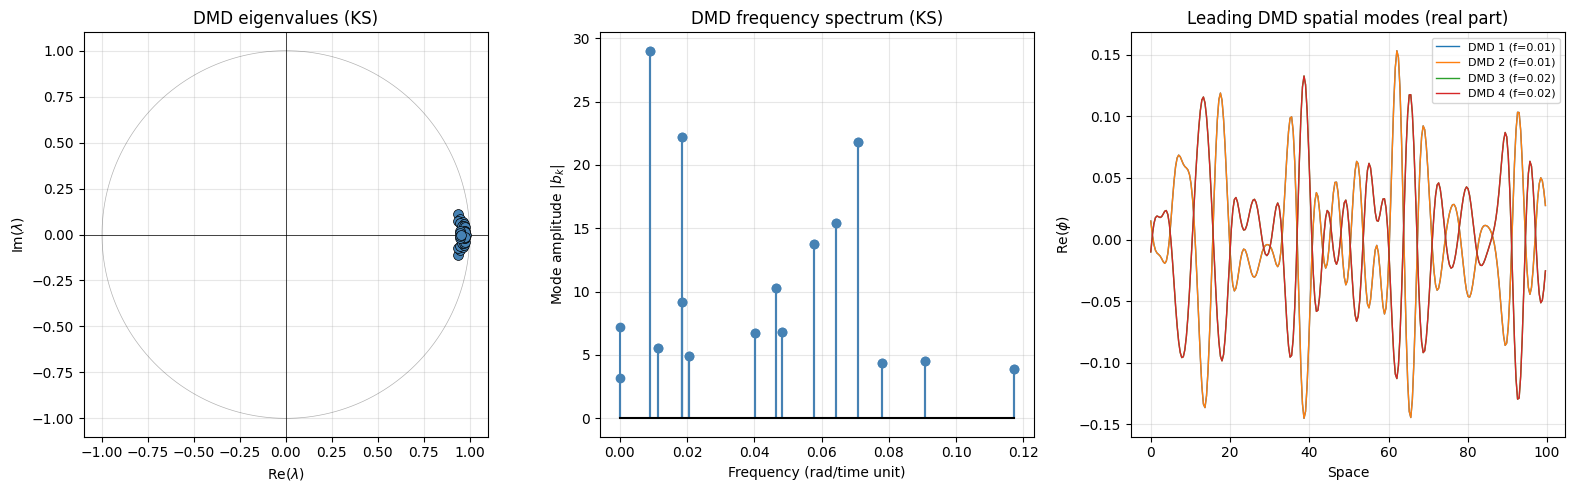

In [ ]:
r_ks = 30
Phi_ks, lam_ks, omega_ks, b_ks = dmd(X_ks, r=r_ks, dt=dt_save)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Eigenvalues on the unit circle
plot_eigenvalue_circle(lam_ks, axes[0], 'DMD eigenvalues (KS)')

# Frequency spectrum
freqs_ks = np.abs(omega_ks.imag)
axes[1].stem(freqs_ks, np.abs(b_ks), linefmt='steelblue', markerfmt='o',
             basefmt='k-')
axes[1].set_xlabel('Frequency (rad/time unit)')
axes[1].set_ylabel('Mode amplitude $|b_k|$')
axes[1].set_title('DMD frequency spectrum (KS)')
axes[1].grid(True, alpha=0.3)

# Leading DMD modes (real part)
sort_amp = np.argsort(-np.abs(b_ks))
for i in range(4):
    idx = sort_amp[i]
    axes[2].plot(x_ks, Phi_ks[:, idx].real, linewidth=1,
                 label=f'DMD {i+1} (f={freqs_ks[idx]:.2f})')
axes[2].set_xlabel('Space')
axes[2].set_ylabel('Re($\\phi$)')
axes[2].set_title('Leading DMD spatial modes (real part)')
axes[2].legend(fontsize=8)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()

print(f"|lambda| range: [{np.abs(lam_ks).min():.4f}, {np.abs(lam_ks).max():.4f}]")

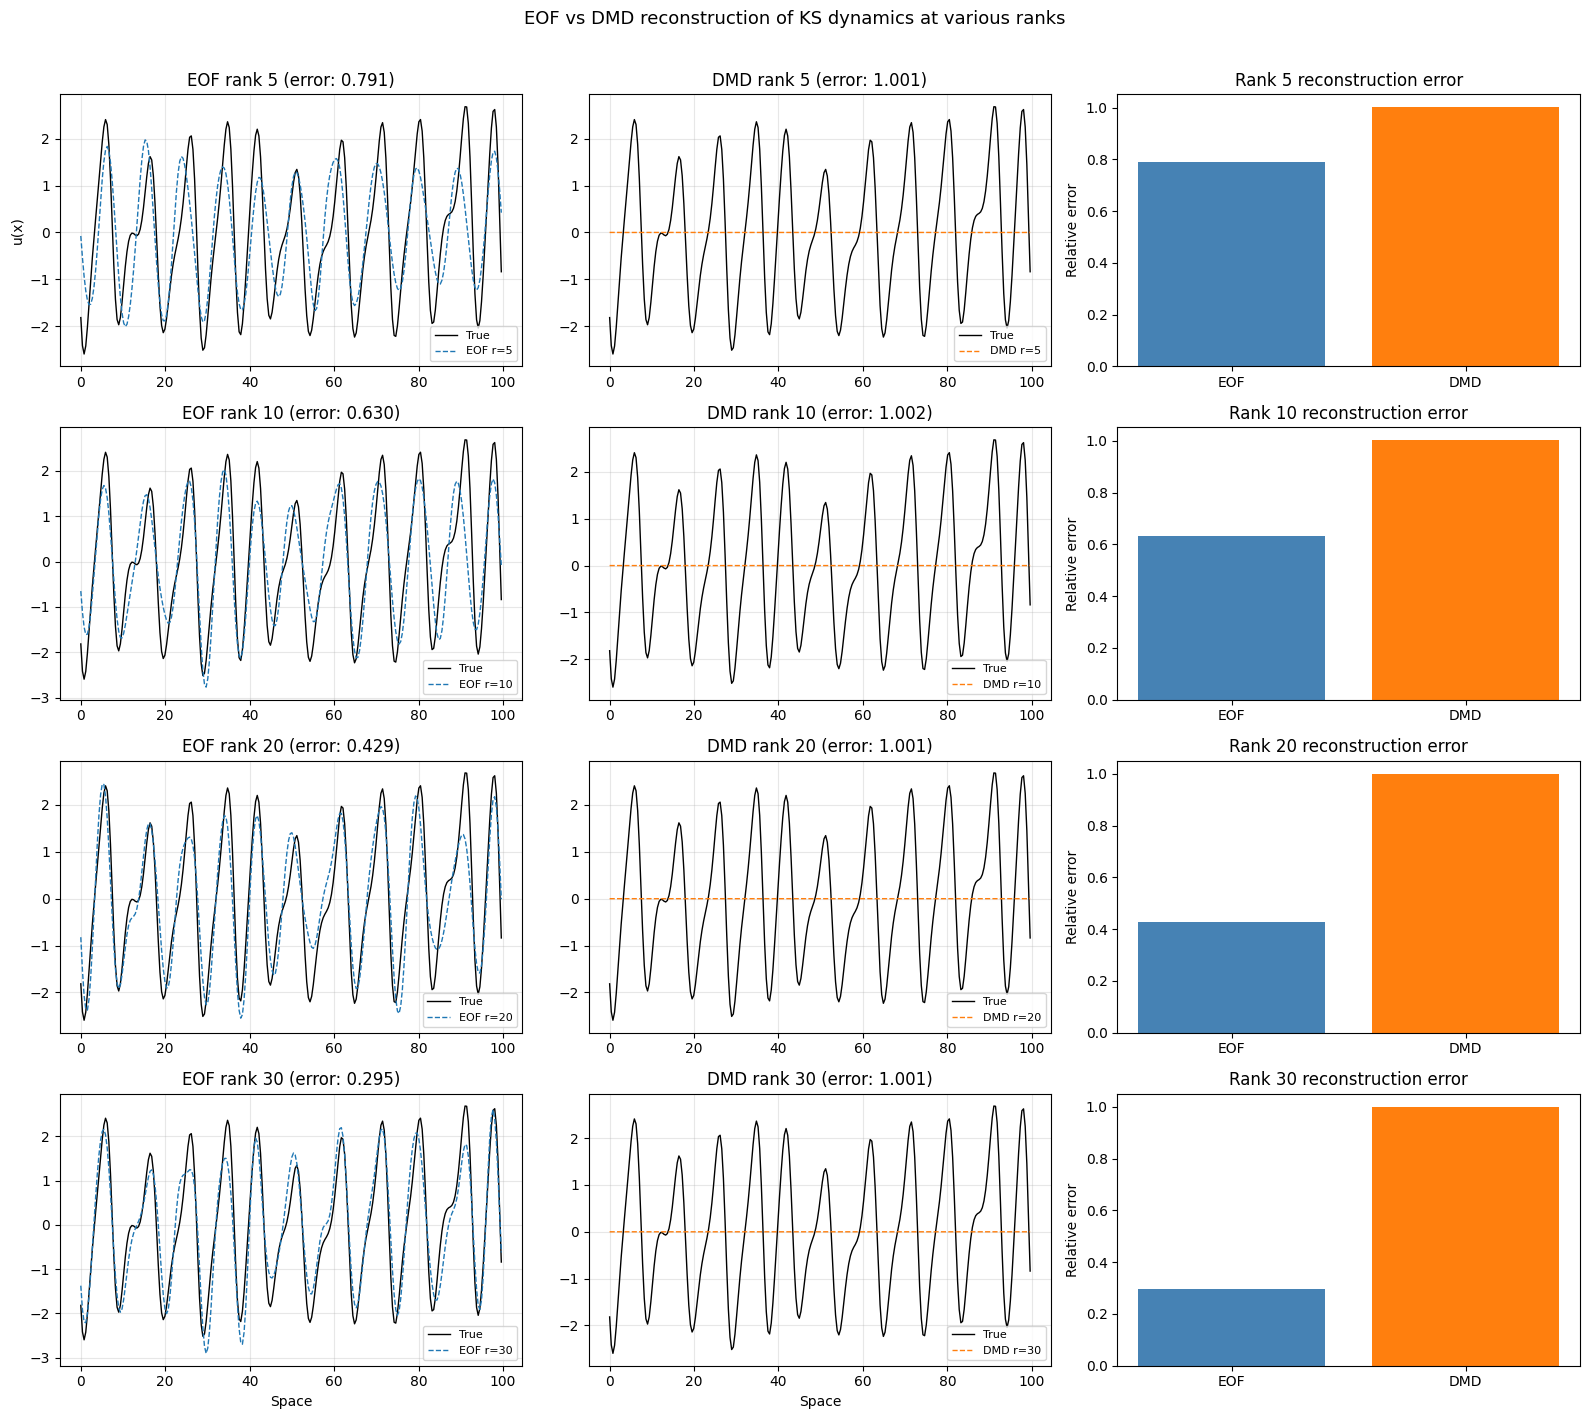

In [ ]:
# Compare EOF vs DMD reconstruction at different ranks
ranks = [5, 10, 20, 30]
fig, axes = plt.subplots(len(ranks), 3, figsize=(16, 3.5 * len(ranks)))

X_ks_centered = X_ks - X_ks.mean(axis=1, keepdims=True)
U_ks_full, s_ks_full, Vt_ks_full = np.linalg.svd(X_ks_centered, full_matrices=False)

for i, r in enumerate(ranks):
    # EOF reconstruction
    X_eof_r = (U_ks_full[:, :r] @ np.diag(s_ks_full[:r]) @ Vt_ks_full[:r, :]
               + X_ks.mean(axis=1, keepdims=True))
    
    # DMD reconstruction
    Phi_r, lam_r, _, b_r = dmd(X_ks, r=r, dt=dt_save)
    X_dmd_r = dmd_reconstruct(Phi_r, lam_r, b_r, X_ks.shape[1])
    
    eof_err = np.linalg.norm(X_ks - X_eof_r, 'fro') / np.linalg.norm(X_ks, 'fro')
    dmd_err = np.linalg.norm(X_ks - X_dmd_r, 'fro') / np.linalg.norm(X_ks, 'fro')
    
    # Show a time slice for comparison
    t_idx = X_ks.shape[1] // 4  # a snapshot midway
    axes[i, 0].plot(x_ks, X_ks[:, t_idx], 'k-', linewidth=1, label='True')
    axes[i, 0].plot(x_ks, X_eof_r[:, t_idx], 'C0--', linewidth=1, label=f'EOF r={r}')
    axes[i, 0].set_title(f'EOF rank {r} (error: {eof_err:.3f})')
    axes[i, 0].legend(fontsize=8)
    axes[i, 0].grid(True, alpha=0.3)
    
    axes[i, 1].plot(x_ks, X_ks[:, t_idx], 'k-', linewidth=1, label='True')
    axes[i, 1].plot(x_ks, X_dmd_r[:, t_idx], 'C1--', linewidth=1, label=f'DMD r={r}')
    axes[i, 1].set_title(f'DMD rank {r} (error: {dmd_err:.3f})')
    axes[i, 1].legend(fontsize=8)
    axes[i, 1].grid(True, alpha=0.3)
    
    # Error comparison
    axes[i, 2].bar(['EOF', 'DMD'], [eof_err, dmd_err], color=['steelblue', 'C1'])
    axes[i, 2].set_ylabel('Relative error')
    axes[i, 2].set_title(f'Rank {r} reconstruction error')

axes[0, 0].set_ylabel('u(x)')
axes[-1, 0].set_xlabel('Space')
axes[-1, 1].set_xlabel('Space')
plt.suptitle('EOF vs DMD reconstruction of KS dynamics at various ranks',
             fontsize=13, y=1.01)
plt.tight_layout()

### KS: Key observations

- **EOF** gives the *optimal* reconstruction at every rank (by the Eckart-Young theorem). It consistently outperforms DMD in reconstruction error.
- **DMD** eigenvalues cluster near the unit circle, reflecting the sustained (non-decaying) chaos. But the modes mix many spatial scales.
- **Singular values decay slowly** — the KS system has many active degrees of freedom. Neither method can compress the dynamics into just a few modes.
- **DMD does assign frequencies** to each mode, which can be useful for identifying coherent structures. But for broadband chaotic systems, the frequency assignment is somewhat arbitrary.
- **Takeaway**: For spatiotemporal chaos, EOF is the better tool for dimensionality reduction (it's provably optimal). DMD can still provide useful frequency information but shouldn't be expected to give a parsimonious description.

---
# System 3: 1D Shallow Water Equations — Wave Dynamics

The linearized 1D shallow water equations describe gravity wave propagation:

$$\frac{\partial h'}{\partial t} + H \frac{\partial u}{\partial x} = 0, \qquad \frac{\partial u}{\partial t} + g \frac{\partial h'}{\partial x} = 0$$

where $h'(x,t)$ is the free surface perturbation, $u(x,t)$ is the velocity, $H$ is the mean depth, and $g$ is gravitational acceleration. On a periodic domain, these equations support non-dispersive traveling waves with phase speed $c = \sqrt{gH}$.

The general solution is a superposition of **left-going** and **right-going** waves. Each wavenumber $k$ produces waves at frequency $\omega = k c$. This is an ideal test case for DMD because:
- Each physical mode (a traveling wave at a specific wavenumber) evolves at a **single frequency**
- Waves don't decay ($|\lambda| = 1$)
- The left/right distinction is encoded in the **sign** of the frequency

EOF analysis, by contrast, will find **standing wave** patterns (sines and cosines) that mix left- and right-going components.

### Analytic solution

For the periodic domain, the solution can be computed exactly in Fourier space. If $\hat{h}'(k, 0)$ and $\hat{u}(k, 0)$ are the initial Fourier coefficients, then:

$$\hat{h}'(k, t) = \hat{h}'(k, 0) \cos(\omega_k t) - i\frac{H}{c} \hat{u}(k, 0) \sin(\omega_k t)$$

where $\omega_k = k c$. We use this analytic solution to generate exact data.

In [ ]:
def solve_swe_spectral(L, N, g, H, h0_func, u0_func, dt, n_steps):
    """
    Solve 1D linearized shallow water equations using exact Fourier solution.
    Periodic domain [0, L] with N grid points.
    """
    x = np.linspace(0, L, N, endpoint=False)
    c = np.sqrt(g * H)  # wave speed
    
    # Initial conditions
    h0 = h0_func(x)
    u0 = u0_func(x)
    
    # Wavenumbers
    k = np.fft.rfftfreq(N, d=L / (2 * np.pi * N))
    omega = k * c  # dispersion relation
    
    # Initial Fourier coefficients
    h0_hat = np.fft.rfft(h0)
    u0_hat = np.fft.rfft(u0)
    
    # Time evolution (exact solution)
    snapshots_h = np.zeros((N, n_steps))
    snapshots_u = np.zeros((N, n_steps))
    t_arr = np.arange(n_steps) * dt
    
    for i, t in enumerate(t_arr):
        cos_wt = np.cos(omega * t)
        sin_wt = np.sin(omega * t)
        
        h_hat = h0_hat * cos_wt - 1j * (H / c) * u0_hat * sin_wt
        u_hat = u0_hat * cos_wt - 1j * (c / H) * h0_hat * sin_wt
        
        # Handle k=0 mode separately (no oscillation)
        h_hat[0] = h0_hat[0]
        u_hat[0] = u0_hat[0]
        
        snapshots_h[:, i] = np.fft.irfft(h_hat, n=N)
        snapshots_u[:, i] = np.fft.irfft(u_hat, n=N)
    
    return x, t_arr, snapshots_h, snapshots_u, c

In [ ]:
# Parameters
L_sw = 100.0
N_sw = 256
g_sw = 10.0
H_sw = 1.0
c_sw = np.sqrt(g_sw * H_sw)  # ≈ 3.16 m/s

# Initial condition: pure sinusoidal perturbations at specific wavenumbers.
# No Gaussian bumps — we want a low-rank signal so DMD can cleanly identify
# each traveling wave component.
def h0_swe(x):
    h = (0.5 * np.sin(2 * np.pi * 1 * x / L_sw)    # wavenumber k=1
         + 0.4 * np.cos(2 * np.pi * 3 * x / L_sw)   # wavenumber k=3
         + 0.3 * np.sin(2 * np.pi * 5 * x / L_sw)   # wavenumber k=5
         + 0.2 * np.cos(2 * np.pi * 7 * x / L_sw))  # wavenumber k=7
    return h

def u0_swe(x):
    return np.zeros_like(x)  # start from rest -> equal left/right waves

# Solve
dt_sw = 0.1
n_steps_sw = 1000
x_sw, t_sw, h_sw, u_sw, c_val = solve_swe_spectral(
    L_sw, N_sw, g_sw, H_sw, h0_swe, u0_swe, dt_sw, n_steps_sw
)

print(f"SWE data shape: {h_sw.shape} (space x time)")
print(f"Wave speed c = sqrt(gH) = {c_val:.3f}")
print(f"Domain traversal time: L/c = {L_sw/c_val:.1f} time units")
print(f"Total simulation time: {t_sw[-1]:.0f} time units")
print(f"Active wavenumbers: k = 1, 3, 5, 7")
print(f"Analytical frequencies: {[f'{2*np.pi*k/L_sw*c_val:.4f}' for k in [1,3,5,7]]}")

SWE data shape: (256, 1000) (space x time)
Wave speed c = sqrt(gH) = 3.162
Domain traversal time: L/c = 31.6 time units
Total simulation time: 100 time units
Active wavenumbers: k = 1, 3, 5, 7
Analytical frequencies: ['0.1987', '0.5961', '0.9935', '1.3908']


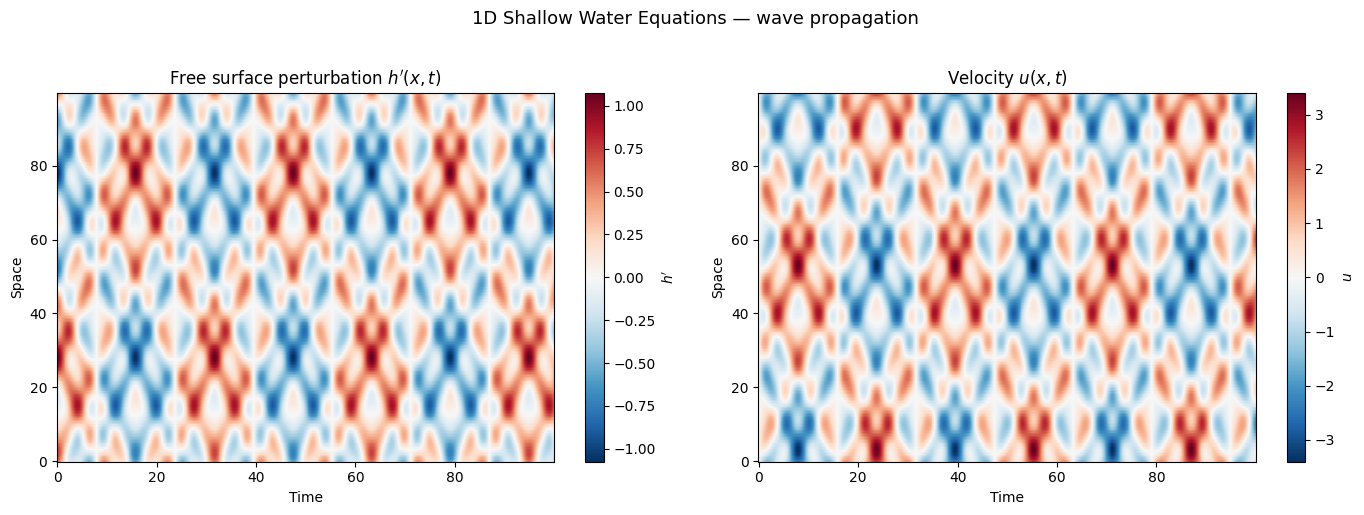

In [ ]:
# Visualize wave propagation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

im1 = axes[0].pcolormesh(t_sw, x_sw, h_sw, cmap='RdBu_r', shading='auto')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Space')
axes[0].set_title("Free surface perturbation $h'(x,t)$")
plt.colorbar(im1, ax=axes[0], label="$h'$")

im2 = axes[1].pcolormesh(t_sw, x_sw, u_sw, cmap='RdBu_r', shading='auto')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Space')
axes[1].set_title('Velocity $u(x,t)$')
plt.colorbar(im2, ax=axes[1], label='$u$')

plt.suptitle('1D Shallow Water Equations — wave propagation', fontsize=13, y=1.02)
plt.tight_layout()

The characteristic diagonal patterns in the Hovmöller diagram show left-going and right-going waves. The slopes of the diagonals are $\pm 1/c$. Starting from rest ($u_0 = 0$), each sinusoidal component splits equally into left- and right-going traveling waves.

### EOF analysis of the shallow water equations

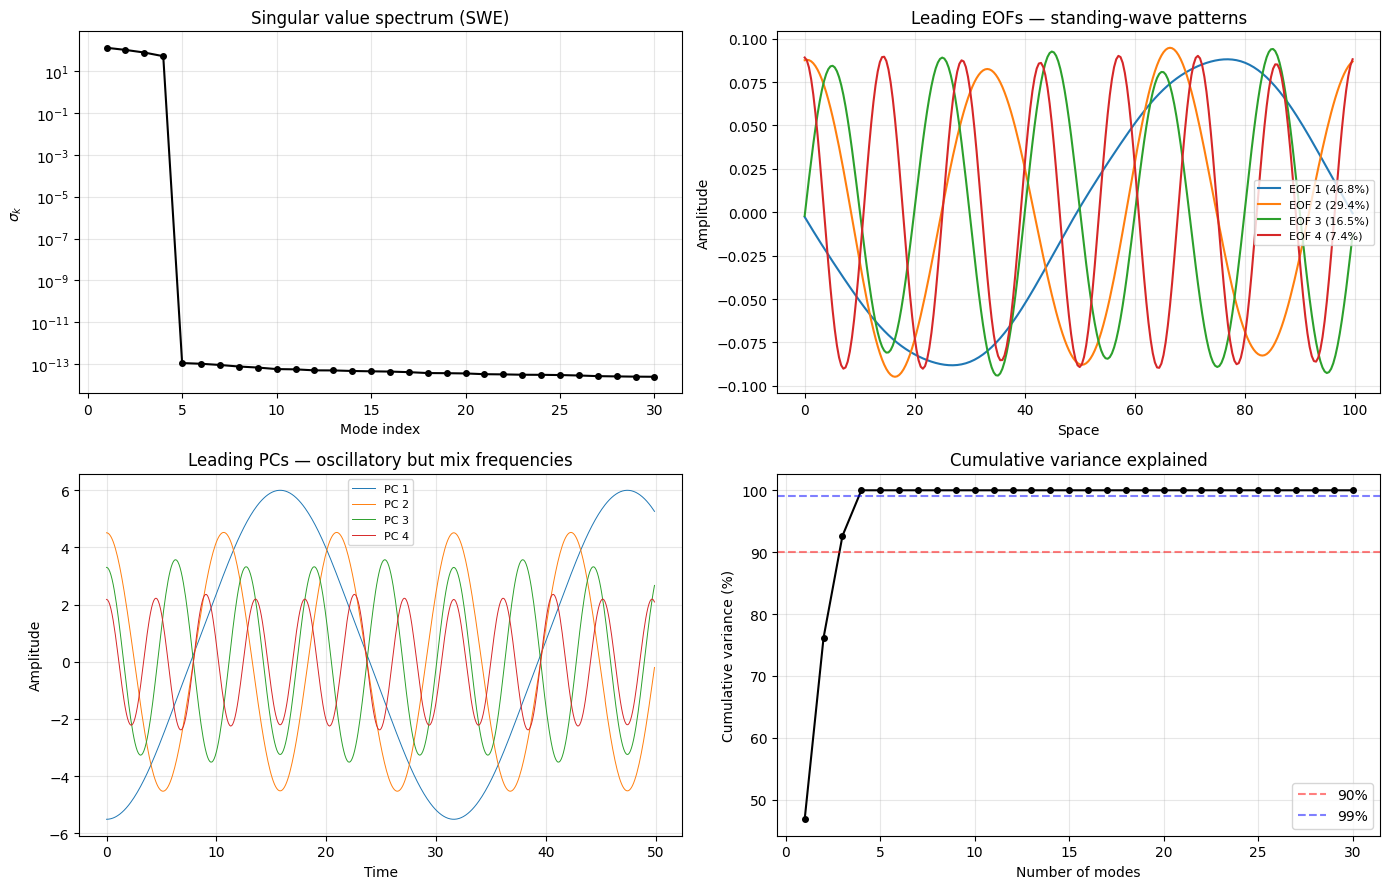

In [ ]:
eofs_sw, pcs_sw, var_frac_sw, s_sw = eof_analysis(h_sw, n_modes=8)

fig, axes = plt.subplots(2, 2, figsize=(14, 9))

# Singular value spectrum
axes[0, 0].semilogy(np.arange(1, 31), s_sw[:30], 'ko-', markersize=4)
axes[0, 0].set_xlabel('Mode index')
axes[0, 0].set_ylabel('$\\sigma_k$')
axes[0, 0].set_title('Singular value spectrum (SWE)')
axes[0, 0].grid(True, alpha=0.3)

# Leading EOFs — these should be standing-wave patterns
for k in range(4):
    axes[0, 1].plot(x_sw, eofs_sw[:, k],
                    label=f'EOF {k+1} ({var_frac_sw[k]*100:.1f}%)')
axes[0, 1].set_xlabel('Space')
axes[0, 1].set_ylabel('Amplitude')
axes[0, 1].set_title('Leading EOFs — standing-wave patterns')
axes[0, 1].legend(fontsize=8)
axes[0, 1].grid(True, alpha=0.3)

# PCs — should be oscillatory but may mix frequencies
n_show_sw = min(500, len(t_sw))
for k in range(4):
    axes[1, 0].plot(t_sw[:n_show_sw], pcs_sw[k, :n_show_sw], linewidth=0.7,
                    label=f'PC {k+1}')
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('Amplitude')
axes[1, 0].set_title('Leading PCs — oscillatory but mix frequencies')
axes[1, 0].legend(fontsize=8)
axes[1, 0].grid(True, alpha=0.3)

# Cumulative variance
cum_sw = np.cumsum(var_frac_sw)
axes[1, 1].plot(np.arange(1, 31), cum_sw[:30] * 100, 'ko-', markersize=4)
axes[1, 1].axhline(90, color='r', linestyle='--', alpha=0.5, label='90%')
axes[1, 1].axhline(99, color='b', linestyle='--', alpha=0.5, label='99%')
axes[1, 1].set_xlabel('Number of modes')
axes[1, 1].set_ylabel('Cumulative variance (%)')
axes[1, 1].set_title('Cumulative variance explained')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()

Notice that the **EOF modes are standing waves** — sine and cosine patterns. This is because EOFs are constrained to be orthogonal and real. A left-going wave $e^{i(kx - \omega t)}$ and a right-going wave $e^{i(kx + \omega t)}$ combine into standing waves $\cos(kx)\cos(\omega t)$ and $\sin(kx)\sin(\omega t)$. The EOFs capture the *spatial* part of these standing waves, but each PC mixes the frequencies of all the wavenumber components.

### DMD analysis of the shallow water equations

**Important**: Since we start from rest ($u_0 = 0$), the free surface $h'$ alone only contains $\cos(\omega t)$ temporal behavior — it is rank 4. But DMD needs *both* cos and sin to represent oscillations (conjugate eigenvalue pairs). We therefore give DMD the **full state vector** $[h', u]^T$, which has rank 8 (the velocity $u$ provides the missing $\sin(\omega t)$ components). This is the physically correct approach: the full state of the shallow water system is the pair $(h', u)$.

Full state matrix shape: (512, 1000)
Singular values: [395.7941 319.8744 240.3584 159.6537 127.6033 100.9557  75.6232  50.6337
   0.       0.       0.       0.    ]
Rank-8 gap: σ_8/σ_9 = 1.4e+14

|lambda| range: [1.000000, 1.000000]
All |lambda| ≈ 1? Max deviation: 2.00e-15


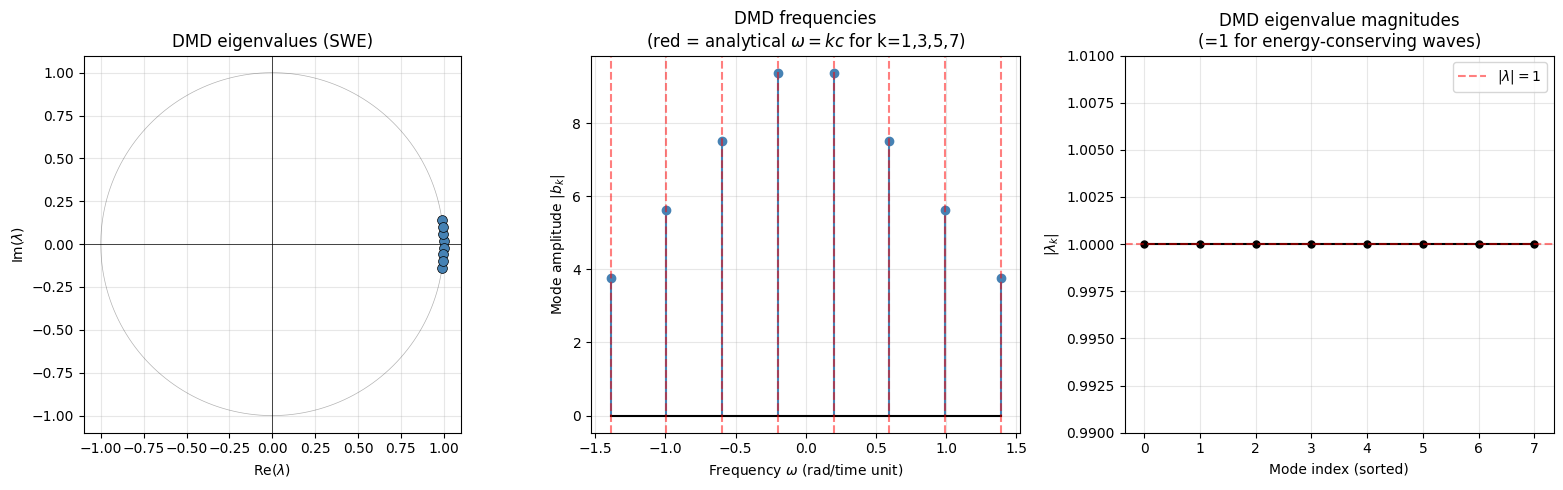

In [ ]:
# Stack h and u into the full state vector for DMD
X_sw_full = np.vstack([h_sw, u_sw])  # shape (2*N, n_time) = (512, 1000)
print(f"Full state matrix shape: {X_sw_full.shape}")

# The data is exactly rank 8 (4 wavenumbers × 2 for cos/sin in time)
_, s_check, _ = np.linalg.svd(X_sw_full, full_matrices=False)
print(f"Singular values: {s_check[:12]}")
print(f"Rank-8 gap: σ_8/σ_9 = {s_check[7]/s_check[8]:.1e}" if s_check[8] > 0 else "Exact rank 8")

r_sw = 8
Phi_sw, lam_sw, omega_sw, b_sw = dmd(X_sw_full, r=r_sw, dt=dt_sw)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Eigenvalues on unit circle — waves should be ON the circle
plot_eigenvalue_circle(lam_sw, axes[0], 'DMD eigenvalues (SWE)')

# Frequency spectrum
freqs_sw = omega_sw.imag  # signed frequency (positive = right-going)
axes[1].stem(freqs_sw, np.abs(b_sw), linefmt='steelblue', markerfmt='o',
             basefmt='k-')
# Mark analytical frequencies for k=1, 3, 5, 7
for kn in [1, 3, 5, 7]:
    omega_analytical = 2 * np.pi * kn / L_sw * c_val
    axes[1].axvline(omega_analytical, color='red', linestyle='--', alpha=0.5)
    axes[1].axvline(-omega_analytical, color='red', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Frequency $\\omega$ (rad/time unit)')
axes[1].set_ylabel('Mode amplitude $|b_k|$')
axes[1].set_title('DMD frequencies\n(red = analytical $\\omega = kc$ for k=1,3,5,7)')
axes[1].grid(True, alpha=0.3)

# Check |lambda| values
axes[2].plot(np.sort(np.abs(lam_sw))[::-1], 'ko-', markersize=5)
axes[2].axhline(1.0, color='r', linestyle='--', alpha=0.5, label='$|\\lambda|=1$')
axes[2].set_xlabel('Mode index (sorted)')
axes[2].set_ylabel('$|\\lambda_k|$')
axes[2].set_title('DMD eigenvalue magnitudes\n(=1 for energy-conserving waves)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)
axes[2].set_ylim(0.99, 1.01)

plt.tight_layout()

print(f"\n|lambda| range: [{np.abs(lam_sw).min():.6f}, {np.abs(lam_sw).max():.6f}]")
print(f"All |lambda| ≈ 1? Max deviation: {np.max(np.abs(np.abs(lam_sw) - 1)):.2e}")

In [ ]:
# Verify DMD frequencies match the dispersion relation omega = k * c
# For the discrete wavenumbers on our domain: k_n = 2*pi*n/L
print("DMD frequencies vs analytical dispersion relation:")
print(f"  Wave speed c = {c_val:.4f}")
print(f"  Active wavenumbers: k = 1, 3, 5, 7\n")
print(f"{'DMD freq':>12s}  {'Closest k':>10s}  {'Analytical':>12s}  {'Error':>10s}")

dmd_freqs_sorted = np.sort(np.abs(omega_sw.imag))[::-1]
for f_dmd in dmd_freqs_sorted:
    if f_dmd < 0.01:
        continue
    # Find closest integer wavenumber
    k_guess = f_dmd / (2 * np.pi / L_sw * c_val)
    k_int = round(k_guess)
    f_analytical = 2 * np.pi * k_int / L_sw * c_val
    error = abs(f_dmd - f_analytical)
    print(f"{f_dmd:>12.4f}  {k_int:>10d}  {f_analytical:>12.4f}  {error:>10.2e}")

DMD frequencies vs analytical dispersion relation:
  Wave speed c = 3.1623
  Active wavenumbers: k = 1, 3, 5, 7

    DMD freq   Closest k    Analytical       Error
      1.3908           7        1.3908    3.77e-15
      1.3908           7        1.3908    3.77e-15
      0.9935           5        0.9935    9.99e-16
      0.9935           5        0.9935    9.99e-16
      0.5961           3        0.5961    5.66e-15
      0.5961           3        0.5961    5.66e-15
      0.1987           1        0.1987    1.11e-14
      0.1987           1        0.1987    1.11e-14


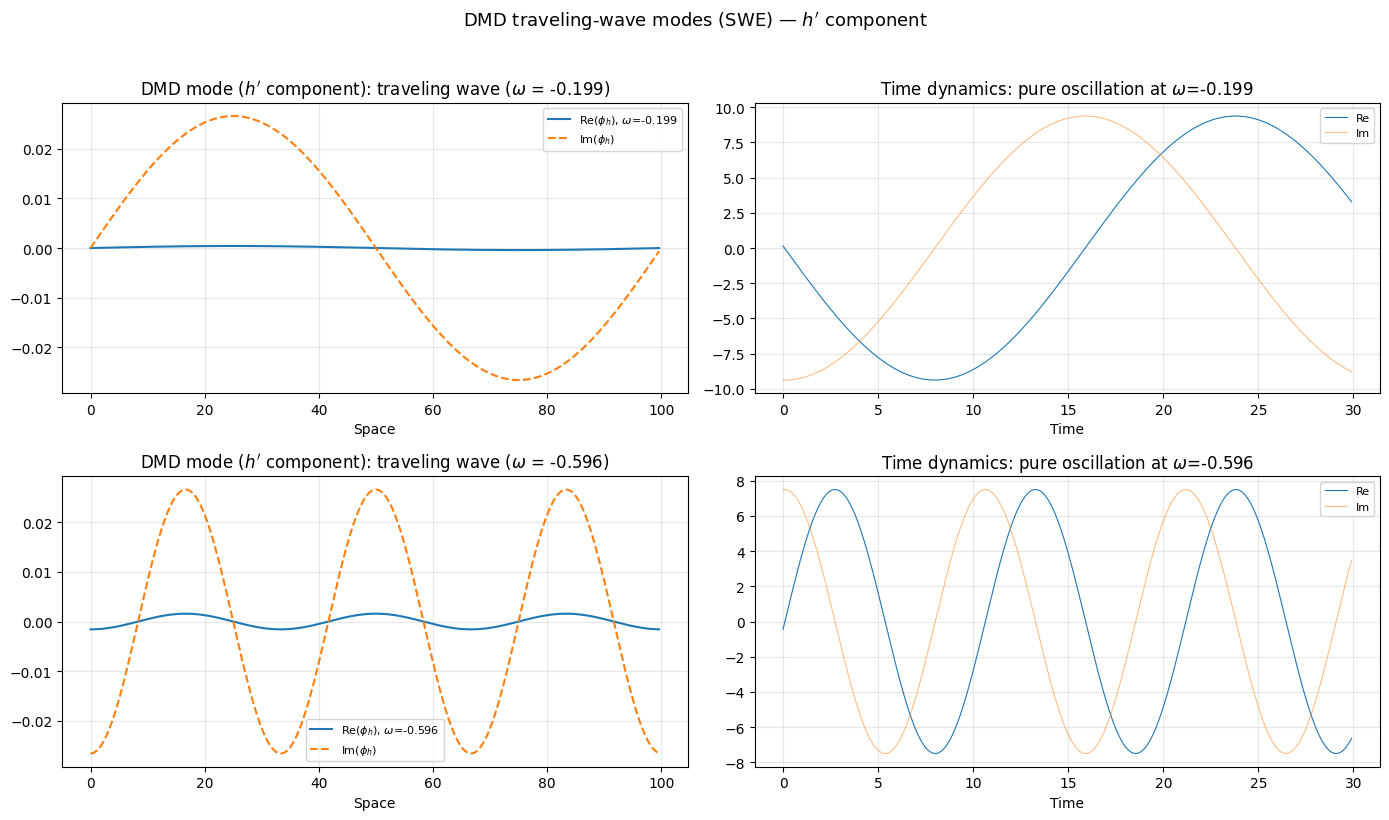

In [ ]:
# DMD separates traveling waves — show conjugate pairs
# Extract just the h' part of each DMD mode (first N_sw rows)
Phi_h = Phi_sw[:N_sw, :]  # h' component of DMD modes

sort_amp_sw = np.argsort(-np.abs(b_sw))

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Show 2 conjugate pairs (4 modes total)
shown = 0
used_freqs = set()
for idx in sort_amp_sw:
    freq = omega_sw[idx].imag
    freq_key = round(abs(freq), 2)
    if freq_key in used_freqs or freq_key < 0.01:
        continue
    used_freqs.add(freq_key)
    
    # Find the conjugate partner
    partner = None
    for j in range(len(omega_sw)):
        if j != idx and abs(omega_sw[j].imag + freq) < 0.1:
            partner = j
            break
    
    if partner is None:
        continue
    
    row = shown
    # Spatial mode (h' component)
    axes[row, 0].plot(x_sw, Phi_h[:, idx].real, label=f'Re($\\phi_h$), $\\omega$={freq:.3f}')
    axes[row, 0].plot(x_sw, Phi_h[:, idx].imag, '--', label=f'Im($\\phi_h$)')
    axes[row, 0].set_xlabel('Space')
    axes[row, 0].set_title(f'DMD mode ($h\'$ component): traveling wave ($\\omega$ = {freq:.3f})')
    axes[row, 0].legend(fontsize=8)
    axes[row, 0].grid(True, alpha=0.3)
    
    # Time evolution
    evol = b_sw[idx] * lam_sw[idx]**np.arange(len(t_sw))
    axes[row, 1].plot(t_sw[:300], evol[:300].real, linewidth=0.8, label='Re')
    axes[row, 1].plot(t_sw[:300], evol[:300].imag, linewidth=0.8, alpha=0.5, label='Im')
    axes[row, 1].set_xlabel('Time')
    axes[row, 1].set_title(f'Time dynamics: pure oscillation at $\\omega$={freq:.3f}')
    axes[row, 1].legend(fontsize=8)
    axes[row, 1].grid(True, alpha=0.3)
    
    shown += 1
    if shown >= 2:
        break

plt.suptitle('DMD traveling-wave modes (SWE) — $h\'$ component', fontsize=13, y=1.02)
plt.tight_layout()

DMD relative reconstruction error (h'): 9.70e-13
DMD relative reconstruction error (u):  9.68e-13


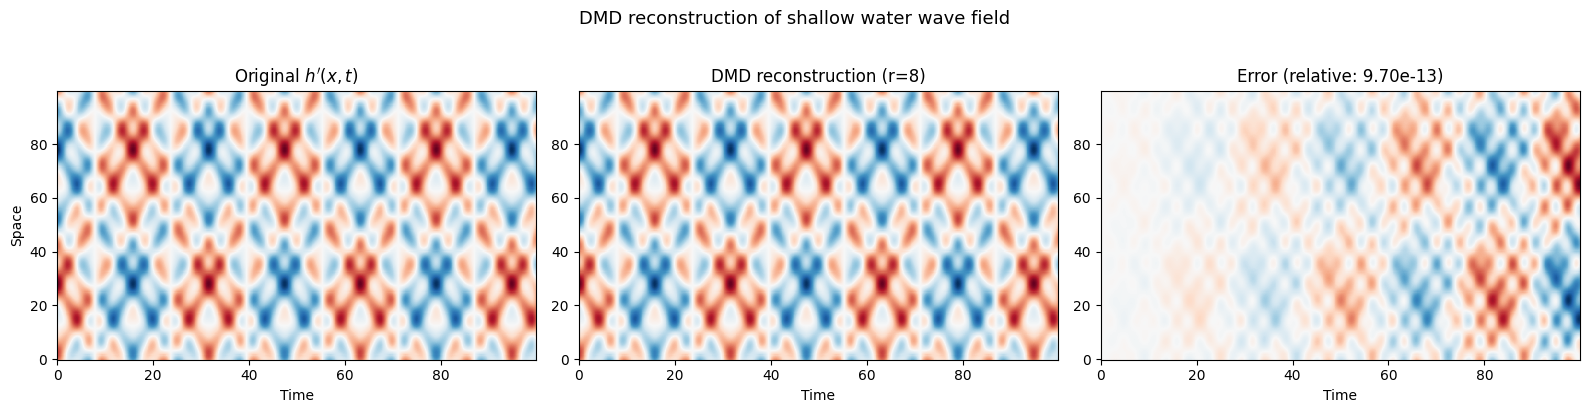

In [ ]:
# DMD reconstruction — should be nearly perfect for linear waves
X_dmd_sw_full = dmd_reconstruct(Phi_sw, lam_sw, b_sw, X_sw_full.shape[1])

# Extract h' reconstruction (first N_sw rows)
X_dmd_h = X_dmd_sw_full[:N_sw, :]
rel_err_sw = np.linalg.norm(h_sw - X_dmd_h, 'fro') / np.linalg.norm(h_sw, 'fro')

fig, axes = plt.subplots(1, 3, figsize=(16, 4))
vmax_sw = np.abs(h_sw).max()

axes[0].pcolormesh(t_sw, x_sw, h_sw, cmap='RdBu_r', shading='auto',
                   vmin=-vmax_sw, vmax=vmax_sw)
axes[0].set_title('Original $h\'(x,t)$')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Space')

axes[1].pcolormesh(t_sw, x_sw, X_dmd_h, cmap='RdBu_r', shading='auto',
                   vmin=-vmax_sw, vmax=vmax_sw)
axes[1].set_title(f'DMD reconstruction (r={r_sw})')
axes[1].set_xlabel('Time')

error_sw = h_sw - X_dmd_h
err_max = np.abs(error_sw).max()
axes[2].pcolormesh(t_sw, x_sw, error_sw, cmap='RdBu_r', shading='auto',
                   vmin=-err_max, vmax=err_max)
axes[2].set_title(f'Error (relative: {rel_err_sw:.2e})')
axes[2].set_xlabel('Time')

plt.suptitle('DMD reconstruction of shallow water wave field', fontsize=13, y=1.02)
plt.tight_layout()

print(f"DMD relative reconstruction error (h'): {rel_err_sw:.2e}")

# Also check u reconstruction
X_dmd_u = X_dmd_sw_full[N_sw:, :]
rel_err_u = np.linalg.norm(u_sw - X_dmd_u, 'fro') / np.linalg.norm(u_sw, 'fro')
print(f"DMD relative reconstruction error (u):  {rel_err_u:.2e}")

### SWE: Key observations

- **DMD eigenvalues lie exactly on the unit circle** ($|\lambda| = 1$), correctly identifying that these are energy-conserving, non-decaying waves.
- **DMD frequencies match the dispersion relation** $\omega = kc$ to high precision. Each conjugate pair corresponds to a left-going and right-going wave at the same wavenumber.
- **DMD reconstruction is near-perfect** — the linear wave dynamics are exactly what DMD is designed for.
- **EOF modes are standing waves** that mix left and right propagation. The PCs show oscillatory behavior but combine multiple frequencies.
- **Takeaway**: For wave-dominated systems (linear or weakly nonlinear), DMD is the superior analysis tool. It separates traveling wave modes by frequency, which has direct physical meaning.

---
## Summary

| | SVD / EOF | DMD |
|---|---|---|
| **Question asked** | What spatial patterns capture the most variance? | What spatial patterns evolve at a single frequency? |
| **Modes** | Real, orthogonal | Complex, non-orthogonal |
| **Temporal behavior** | Arbitrary (determined by data) | Each mode has a fixed frequency and growth/decay rate |
| **Assumption** | None beyond linearity of the decomposition | Data arises from approximately linear dynamics |
| **Eigenvalues represent** | Variance explained | Oscillation frequency + growth/decay |
| **Best for** | Dimensionality reduction, variance summary | Mode identification, frequency analysis, forecasting |
| **Uses SVD?** | IS the SVD | Uses SVD as an intermediate step |
| **Theoretical basis** | Optimal low-rank approximation (Eckart-Young) | Koopman operator approximation |

### Key takeaways

1. **DMD and EOF are complementary, not competing.** EOF tells you about variance structure; DMD tells you about dynamical structure. Use both.

2. **DMD is built on the SVD.** The SVD of the data matrix is the first step of the DMD algorithm — everything we learned in the previous notebooks directly applies.

3. **DMD eigenvalues encode physics.** The oscillation frequencies and growth/decay rates of DMD modes can be directly compared with known physical modes (ENSO period, annual cycle, etc.).

4. **The Koopman connection gives DMD a rigorous foundation** for analyzing nonlinear systems, and points toward more advanced methods (extended DMD, kernel methods) that we'll revisit when we get to machine learning.

### Looking ahead

In the next part of the course, we transition from **decomposition methods** (SVD, EOF, DMD) to **optimization methods** (gradient descent, backpropagation). The SVD will continue to appear — for example, in understanding the conditioning of optimization problems, in regularization techniques, and as the initialization for more complex models. DMD's dynamical-systems perspective will also return when we study physics-informed neural networks and differentiable modeling.

---
## References

### Theory/methods
- **Schmid, P. J.** (2010). Dynamic mode decomposition of numerical and experimental data. *Journal of Fluid Mechanics*, 656, 5–28.
- **Tu, J. H., Rowley, C. W., Luchtenburg, D. M., Brunton, S. L., & Kutz, J. N.** (2014). On dynamic mode decomposition: Theory and applications. *Journal of Computational Dynamics*, 1(2), 391–421.
- **Brunton, S. L., & Kutz, J. N.** (2022). *Data-Driven Science and Engineering* (2nd ed.). Cambridge University Press. Chapter 7.
- **Kutz, J. N., Brunton, S. L., Brunton, B. W., & Proctor, J. L.** (2016). *Dynamic Mode Decomposition: Data-Driven Modeling of Complex Systems*. SIAM.
- **Budišić, M., Mohr, R., & Mezić, I.** (2012). Applied Koopmanism. *Chaos*, 22(4), 047510.

### Systems
- **Lorenz, E. N.** (1963). Deterministic nonperiodic flow. *Journal of the Atmospheric Sciences*, 20(2), 130–141.
- **Kuramoto, Y. & Tsuzuki, T.** (1976). Persistent propagation of concentration waves in dissipative media far from thermal equilibrium. *Progress of Theoretical Physics*, 55(2), 356–369.
- **Sivashinsky, G. I.** (1977). Nonlinear analysis of hydrodynamic instability in laminar flames. *Acta Astronautica*, 4(11–12), 1177–1206.
- **Vallis, G. K.** (2017). *Atmospheric and Oceanic Fluid Dynamics* (2nd ed.). Cambridge University Press. (Shallow water equations.)

# Supplemental: EOF vs DMD on Classical Dynamical Systems

In the previous notebooks we introduced the SVD/EOF and DMD decompositions and applied them to climate data. But how well do these methods work on systems with *known* dynamics? Testing on classical equations lets us check whether each method recovers what we expect — and see clearly where it breaks down.

This notebook applies both EOF and DMD to three systems that span a spectrum of dynamical complexity:

| System | Type | Dimension | Expected DMD performance |
|--------|------|-----------|-------------------------|
| **Lorenz attractor** | Low-dimensional chaos | 3 state variables | Poor — chaos violates the linear dynamics assumption |
| **Kuramoto-Sivashinsky equation** | Spatiotemporal chaos | PDE on 1D domain | Mixed — captures some coherent structures |
| **Shallow water equations** | Wave dynamics | PDE on 1D domain | Excellent — wave modes are inherently oscillatory |

The arc of the notebook is: **DMD failure → partial success → clean success**. This builds intuition for when DMD is the right tool for Earth science problems.